In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── your cleaning steps ─────────────────────────
df = pd.read_csv('spiff_data.csv')

df.rename(columns={'gurkor':'cucumbers'}, inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

mask = df.columns != 'day'
for col in df.columns[mask]:
  is_1000 = df[col] == 1000.0
  df.loc[is_1000, col] = df[col].shift(1)[is_1000]

#df.loc[:, mask] = df.loc[:, mask].replace(1000.0, np.nan)

#df['day'] = pd.to_datetime(df['day'], errors='coerce')
df['day'] = pd.to_datetime('2000-01-01') + pd.to_timedelta(df['day'] - 1, unit='D')
df.set_index('day', inplace=True)

# Drop the last 200 values, which we are supposed to extrapolate.
df = df[:-200]

# Create train and validation sets of df, using 200 values to validate
df_train = df[:-200]
df_validation = df[-200:]

# Interpolate the gaps in df_train (linear interpolation)
df_interpolated = df.interpolate(method='linear', limit_direction='both')

cucumbers_interpolated = df_interpolated['cucumbers']

#df['cucumbers'][:300].plot()
#cucumbers_interpolated[197:247].plot(color='orange')

# Create train and validation data
train_data = df_interpolated['slingshots']
true_future = df_validation['slingshots']
train_data.shape, true_future.shape

((5256,), (200,))

In [3]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.6 MB/s eta 0:00:00


In [4]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00


In [5]:
# Required for pmdarima (auto_arima) to work
!pip install numpy==1.24.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is 

In [7]:
df

,cucumbers,guitars,slingshots,stocks,sugar,water,tranquillity
day,,,,,,,
2000-01-01,6.154653,2.794285,2.136536,10.653684,3.324896,3.896149,7.755880
2000-01-02,6.189623,2.843068,2.113582,10.674465,3.355736,3.899915,7.781310
2000-01-03,6.168641,2.839644,2.116336,10.822372,3.336461,3.897404,7.886205
2000-01-04,6.156401,2.823384,2.096137,10.848804,3.288274,3.901170,7.848061
2000-01-05,6.124929,2.832798,2.099810,10.860731,3.303694,3.905355,7.883026
...,...,...,...,...,...,...,...
2014-05-18,13.790362,8.236738,6.451460,6.706903,2.972465,8.751953,11.767324
2014-05-19,13.798624,8.134064,6.406032,6.677940,2.960002,8.730038,11.830896
2014-05-20,13.800276,8.191484,6.444321,6.655631,2.837448,8.748910,12.129688


# Models used for extrapolation (horizon 200)


- Naive: Last observed value is extentended 200 days into the future.

- Prophet (default, no tuning)

- Monte Carlo ARIMA+GARCH


## Validation

Use rolling window cross-validation with RMSE, MAE, and MAPE.
Compare models using statistical tests (AIC) and visualizations.

## Final Forecast:

Fit the best model (based on validation metrics) on the full 5,200 observations.
Generate 200-step-ahead forecasts with confidence intervals.

## Reporting:

Summarize results in a table comparing RMSE, MAE, and MAPE across models.
Provide plots of forecasts and confidence intervals.

# BOX-COX TRANSFORMED DATA

In [54]:
from scipy.stats import boxcox
from scipy.stats import boxcox_normmax

# --- Guerrero lambda estimation ---
def guerrero_lambda(series, period=None):
    """Approximate Guerrero method for Box-Cox lambda selection."""
    series = series.dropna()
    if (series <= 0).any():
        raise ValueError("Guerrero requires all positive values")
    if period is None:
        period = max(10, len(series) // 10)  # heuristic fallback
    rolling_var = series.rolling(window=period, center=True, min_periods=1).var()
    mean_var_ratio = rolling_var.mean() / series.var()
    return max(-2, min(2, np.log(mean_var_ratio)))

# Containers
mle_transformed = {}
guerrero_transformed = {}
lambda_results = []

# Process each column
for col in df_interpolated.columns:
    if col == 'day':
        continue
    series = df_interpolated[col].dropna()

    if (series <= 0).any():
        print(f"Skipping {col} (contains non-positive values)")
        continue

    try:
        # Box-Cox MLE
        lambda_mle = boxcox_normmax(series, method='mle')
        transformed_mle = boxcox(series, lmbda=lambda_mle)

        # Guerrero lambda
        lambda_guerrero = guerrero_lambda(series)
        transformed_guerrero = boxcox(series, lmbda=lambda_guerrero)

        # Store
        mle_transformed[col] = transformed_mle
        guerrero_transformed[col] = transformed_guerrero
        lambda_results.append({
            "Instrument": col,
            "BoxCox_MLE_Lambda": round(lambda_mle, 6),
            "BoxCox_Guerrero_Lambda": round(lambda_guerrero, 6)
        })

        print(f"{col}: MLE λ = {lambda_mle:.4f}, Guerrero λ = {lambda_guerrero:.4f}")

    except Exception as e:
        print(f"Error processing {col}: {e}")

# Create result DataFrames
df_boxcox_mle = pd.DataFrame(mle_transformed)
df_boxcox_guerrero = pd.DataFrame(guerrero_transformed)
df_lambdas = pd.DataFrame(lambda_results)
guerrero_lambdas = df_lambdas['BoxCox_Guerrero_Lambda']
mle_lambdas = df_lambdas['BoxCox_MLE_Lambda']

# fix index
series_names = ['cucumbers', 'guitars', 'slingshots', 'stocks', 'sugar', 'water', 'tranquillity']
guerrero_lambdas = pd.Series(guerrero_lambdas.values, index=series_names)
mle_lambdas = pd.Series(mle_lambdas.values, index=series_names)

cucumbers: MLE λ = -1.0249, Guerrero λ = -2.0000
guitars: MLE λ = 0.5490, Guerrero λ = -1.4090
slingshots: MLE λ = -0.0540, Guerrero λ = -1.7675
stocks: MLE λ = -2.0141, Guerrero λ = -1.6483
sugar: MLE λ = 0.2617, Guerrero λ = -1.5525
water: MLE λ = -0.0249, Guerrero λ = -2.0000
tranquillity: MLE λ = -0.8244, Guerrero λ = -1.3472


In [61]:
mle_lambdas

,0
cucumbers,-1.024928
guitars,0.549039
slingshots,-0.054016
stocks,-2.014102
sugar,0.261747
water,-0.024859
tranquillity,-0.824383


# This version uses BoxCox for ARIMA+GARCH

# Further down is a version that does not use BoxCox

In [76]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from collections import Counter
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller

# R§emove some version warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

results = []
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=200)

for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Prepare data
    train_data = df_interpolated[series_name][:-200]
    true_future = df_interpolated[series_name][-200:]

    train_data_boxcox = df_boxcox_mle[series_name][:-200]
    true_future_boxcox = df_boxcox_mle[series_name][-200:]

    train_data.index = pd.DatetimeIndex(train_data.index, freq='D')
    train_data_boxcox.index = pd.DatetimeIndex(train_data.index, freq='D')

    # Lambda vals to inverse boxcox transform
    lambda_val = mle_lambdas[series_name]

    returns = np.log(train_data).diff().dropna()
    returns_boxcox = np.log(train_data_boxcox / train_data_boxcox.shift(1)).dropna()

    print("RETURNS BOXCOX STATIONARY TEST")
    adf_result = adfuller(returns_boxcox)
    print(f"ADF p-value: {adf_result[1]}")

    returns.index = pd.DatetimeIndex(returns.index).to_period('D').to_timestamp(freq='D')
    returns_boxcox.index = pd.DatetimeIndex(returns_boxcox.index).to_period('D').to_timestamp(freq='D')

    # Check variance of returns
    returns_var = np.var(returns)
    print(f"Series {series_name}, Variance of returns (original): {returns_var}")
    if returns_var < 1e-6:
        print(f"⚠️ Warning: Low variance (ORIGINAL) in returns for {series_name}, ARIMA may be unstable")

    returns_var_boxcox = np.var(returns_boxcox)
    print(f"Series {series_name}, Variance of returns (BoxCox): {returns_var_boxcox}")
    if returns_var_boxcox < 1e-6:
        print(f"⚠️ Warning: Low variance (BOXCOX) in returns for {series_name}, ARIMA may be unstable")

    # Compute scaling factor for Monte Carlo simulation
    variance_ratio = returns_var / returns_var_boxcox
    scaling_factor = np.sqrt(variance_ratio)
    print(f"Series {series_name}, Scaling factor: {scaling_factor}")

    # Lists to store metrics across folds
    fold_metrics = []

    if (train_data <= 0).any() or (train_data_boxcox <= 0).any():
      print(f"⚠️ Warning: Non-positive values in train_data or train_data_boxcox for {series_name}")


    # Rolling window CV
    for fold, (train_idx, test_idx) in enumerate(tscv.split(returns_boxcox)):
        train_returns_boxcox = returns_boxcox.iloc[train_idx]
        train_prices = train_data.iloc[train_idx]

        test_prices_boxcox = train_data_boxcox.iloc[test_idx]
        test_prices = train_data.iloc[test_idx]

        # Naive baseline model
        naive_forecast = np.full(200, train_data.iloc[train_idx[-1]])
        naive_rmse = np.sqrt(((naive_forecast - train_data.iloc[test_idx]) ** 2).mean())
        naive_mae = mean_absolute_error(train_data.iloc[test_idx], naive_forecast)
        # scale mape to match prophets percentage format
        naive_mape = mean_absolute_percentage_error(train_data.iloc[test_idx], naive_forecast)*100
        fold_metrics.append({'fold': fold, 'model': 'naive', 'rmse': naive_rmse, 'mae': naive_mae, 'mape': naive_mape})

        # Prophet
        prophet_df = pd.DataFrame({
            'ds': train_data.iloc[train_idx].index,
            'y': train_data.iloc[train_idx].values})

        # can try setting things like daily_seasonality=True, yearly_seasonality=True)
        # but right now just use default
        prophet_model = Prophet()
        prophet_model.fit(prophet_df)
        future = prophet_model.make_future_dataframe(periods=200, freq='D')
        prophet_forecast = prophet_model.predict(future)

        # Align forecast with test period
        test_dates = pd.to_datetime(train_data.iloc[test_idx].index).normalize()
        # Prophet returns full forecast; grab the last 200 matching future dates
        forecast_start = test_dates.min()
        forecast_end = test_dates.max()
        prophet_point_forecast = prophet_forecast[
            (prophet_forecast['ds'] >= forecast_start) & (prophet_forecast['ds'] <= forecast_end)
        ]['yhat'].values

        prophet_rmse = np.sqrt(((prophet_point_forecast - train_data.iloc[test_idx]) ** 2).mean())
        prophet_mae = mean_absolute_error(train_data.iloc[test_idx], prophet_point_forecast)
        prophet_mape = mean_absolute_percentage_error(train_data.iloc[test_idx], prophet_point_forecast) * 100
        fold_metrics.append({
            'fold': fold,
            'model': 'prophet',
            'rmse': prophet_rmse,
            'mae': prophet_mae,
            'mape': prophet_mape
        })

        #ARIMA order selection
        arima_model = auto_arima(train_returns_boxcox, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
        arima_order = arima_model.order
        arima_result = ARIMA(train_returns_boxcox, order=arima_order).fit()

        # Ljung - Box and ARCH-LM tests
        residuals_boxcox = arima_result.resid.dropna()
        arch_needed = False
        if len(residuals_boxcox) < 10 or np.isclose(residuals_boxcox.var(), 0):
          print(f"Fold {fold}: Residuals too few / variance ~ 0 - skip tests.")
        else:
          max_lag = min(20, len(residuals_boxcox) // 5)
          lb_p = acorr_ljungbox(residuals_boxcox, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
          arch_p = het_arch(residuals_boxcox, nlags=min(10, max_lag))[1]
          print(f"Fold {fold}, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
          print(f"Fold {fold}, ARCH-LM p={arch_p:.3f}")
          arch_needed = arch_p < 0.05

        # GARCH model

        # Default to zero if GARCH not needed
        garch_result = None
        var_garch = np.zeros(200)

        if arch_needed:
          garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (2, 3), (3, 3), (4,3), (3,4)]
          best_garch_aic = float('inf')
          best_garch_order = None
          best_garch_result = None

          for garch_order in garch_orders:
              garch_model = arch_model(residuals_boxcox, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
              garch_result = garch_model.fit(disp='off')

              if garch_result.aic < best_garch_aic:
                  best_garch_aic = garch_result.aic
                  best_garch_order = garch_order
                  best_garch_result = garch_result

          # Check GARCH stationarity (sum of alpha + beta < 1)
          alpha = best_garch_result.params.get('alpha[1]', 0)
          beta = best_garch_result.params.get('beta[1]', 0)
          if alpha + beta >= 1:
              print(f"⚠️ Warning: GARCH model may be non-stationary for {series_name}, fold {fold}, alpha + beta = {alpha + beta}")

          garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
          var_garch = garch_forecast.variance.values[-1, :]

        print(" -------- GARCH VARIANCE------ ")
        print(f"Fold {fold}, Max GARCH variance: {var_garch.max()}")

        # Monte Carlo Simulation for ARIMA+GARCH on Box-Cox data
        horizon = 200
        n_simulations = 100
        last_price_boxcox = train_data_boxcox.iloc[-1]
        last_return = arima_result.resid.iloc[-1]

        phi = arima_result.params.get('ar.L1', 0)
        theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
        mu = arima_result.params.get('const', 0)

        simulated_paths_boxcox = np.zeros((n_simulations, horizon))
        for i in range(n_simulations):
            r_prev = last_return
            eps_prev = [0.0] * arima_order[2]
            sim_returns = []
            for t in range(horizon):
                std_dev = np.sqrt(var_garch[t])
                eps_t = np.random.normal(0, std_dev)

                ma_part = sum(theta[j] * eps_prev[j] for j in range(arima_order[2])) if arima_order[2] > 0 else 0

                r_t = mu + phi * r_prev + ma_part + eps_t
                sim_returns.append(r_t)

                r_prev = r_t
                eps_prev = [eps_t] + eps_prev[:-1]

            # Cumulative log returns and exponentiate to get back to Box-Cox scale
            sim_log_values = np.log(last_price_boxcox) + np.cumsum(sim_returns)
            sim_values_boxcox = np.exp(sim_log_values)
            simulated_paths_boxcox[i, :] = sim_values_boxcox

        # Debug: Check for extreme values
        max_boxcox = np.max(simulated_paths_boxcox)
        min_boxcox = np.min(simulated_paths_boxcox)
        print(f"Fold {fold}, Series {series_name}, Max simulated prices (boxcox): {max_boxcox}")
        print(f"Fold {fold}, Series {series_name}, Min simulated prices (boxcox): {min_boxcox}")


        simulated_paths = np.zeros((n_simulations, horizon))

        # Clip so that we don't get NaN when inverse boxcox.
        # This might cause some problems, however no solution found.
        if lambda_val < 0:
          max_valid = 1 / abs(lambda_val)
          print(f"Fold {fold}, Series {series_name}, Clipping sim_values_boxcox to max {max_valid}")
          simulated_paths_boxcox = np.clip(simulated_paths_boxcox, 1e-10, max_valid * 0.999)  # Slight buffer

        for i in range(n_simulations):
            simulated_paths[i, :] = inv_boxcox(simulated_paths_boxcox[i, :], lambda_val)

        if np.any(np.isnan(simulated_paths)):
            print(f"⚠️ Warning: NaN values in simulated paths for {series_name} in final forecast")
            # Debug: identify problematic values
            for i in range(n_simulations):
              if np.any(np.isnan(simulated_paths[i, :])):
                print(f"NaN in simulation {i}, sim_values_boxcox: min={np.min(simulated_paths_boxcox[i, :])}, max={np.max(simulated_paths_boxcox[i, :])}")

        arima_garch_forecast = simulated_paths.mean(axis=0)
        arima_garch_lower_bound = np.percentile(simulated_paths, 5, axis=0)
        arima_garch_upper_bound = np.percentile(simulated_paths, 95, axis=0)

        print(f"Fold {fold}, Max simulated prices: {simulated_paths.max()}")
        print(f"Fold {fold}, Max point forecast: {arima_garch_forecast.max()}")

        rmse = np.sqrt(((arima_garch_forecast - test_prices) ** 2).mean())
        mae = mean_absolute_error(test_prices, arima_garch_forecast)
        mape = mean_absolute_percentage_error(test_prices, arima_garch_forecast) * 100 # Scale mape to match prophet's percentage format

        fold_metrics.append({
            'fold': fold,
            'model': 'arima_garch',
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'arima_order': arima_order,
            'garch_order': best_garch_order if arch_needed else None
        })

    # Average metrics across folds
    metrics_df = pd.DataFrame(fold_metrics)
    avg_metrics = metrics_df.groupby('model')[['rmse', 'mae', 'mape']].mean().reset_index()

    # Store CV results
    for _, row in avg_metrics.iterrows():
        result = {
            'series': series_name,
            'model': row['model'],
            'rmse': row['rmse'],
            'mae': row['mae'],
            'mape': row['mape']
        }
        if row['model'] == 'arima_garch':
            # Get most frequent orders across folds
            arima_orders = [str(m['arima_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            garch_orders = [str(m['garch_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            result['arima_order'] = eval(Counter(arima_orders).most_common(1)[0][0])
            result['garch_order'] = eval(Counter(garch_orders).most_common(1)[0][0])
        results.append(result)


    # ---------------  Final Forecasts ------------
    # Use full df_interpolated
    train_data = df_interpolated[series_name]
    train_data_boxcox = df_boxcox_mle[series_name]
    returns_boxcox = np.log(train_data_boxcox / train_data_boxcox.shift(1)).dropna()

    #Generate future dates for 200 days beyond the last observation
    last_date = train_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=200, freq='D')

    # Naive Baseline
    naive_final_forecast = np.full(200, train_data.iloc[-1])
    #Estimate confidence intervals based on histrocial standard deivation
    hist_std = train_data.diff().dropna().std() * np.sqrt(np.arange(1,201))
    naive_lower_bound = naive_final_forecast - 1.96 * hist_std
    naive_upper_bound = naive_final_forecast + 1.96 * hist_std

    results.append({
        'series': series_name,
        'model': 'naive',
        'final_forecast': naive_final_forecast,
        'lower_bound': naive_lower_bound,
        'upper_bound': naive_upper_bound,
        'forecast_dates': future_dates
    })

    # Prophet
    prophet_df = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
    prophet_model = Prophet()
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=200)
    prophet_forecast = prophet_model.predict(future)
    prophet_final_forecast = prophet_forecast['yhat'].values
    prophet_lower_bound = prophet_forecast['yhat_lower'].values
    prophet_upper_bound = prophet_forecast['yhat_upper'].values
    results.append({
        'series': series_name,
        'model': 'prophet',
        'final_forecast': prophet_final_forecast,
        'lower_bound': prophet_lower_bound,
        'upper_bound': prophet_upper_bound,
        'forecast_dates': future_dates
    })

    # ARIMA order selection
    arima_model = auto_arima(returns_boxcox, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
    arima_order = arima_model.order
    arima_result = ARIMA(returns_boxcox, order=arima_order).fit()

    # Ljung-Box and ARCH-LM tests
    residuals_boxcox = arima_result.resid.dropna()
    arch_needed = False

    if len(residuals_boxcox) < 10 or np.isclose(residuals_boxcox.var(), 0):
        print("⚠️ Final Forecast: Residuals too few / variance ≈ 0 – skip tests.")
    else:
        max_lag = min(20, len(residuals_boxcox)//5)
        lb_p = acorr_ljungbox(residuals_boxcox, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
        arch_p = het_arch(residuals_boxcox, nlags=min(10, max_lag))[1]
        print(f"⚠️ Final Forecast, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
        print(f"⚠️ Final Forecast, ARCH-LM p={arch_p:.3f}")
        arch_needed = arch_p < 0.05

    garch_result = None
    var_garch = np.zeros(200)

    if arch_needed:
      garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (2, 3), (3, 3)]
      best_garch_aic = float('inf')
      best_garch_order = None
      best_garch_result = None

      for garch_order in garch_orders:
          garch_model = arch_model(residuals_boxcox, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
          garch_result = garch_model.fit(disp='off')
          if garch_result.aic < best_garch_aic:
              best_garch_aic = garch_result.aic
              best_garch_order = garch_order
              best_garch_result = garch_result

      if best_garch_result is not None:
            std_resid = best_garch_result.std_resid.dropna()

            # Ljung-Box on standardized residuals
            lb_p_post = acorr_ljungbox(std_resid, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]

            # ARCH-LM test on stadardized residuals
            arch_p_post = het_arch(std_resid, nlags=min(10, max_lag))[1]

            print(f"⚠️ Post-GARCH Ljung-Box p = {lb_p_post:.3f}")
            print(f"⚠️ Post-GARCH ARCH-LM p = {arch_p_post:.3f}")

      garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
      var_garch = garch_forecast.variance.values[-1, :]

    # Monte Carlo Simulation for ARIMA+GARCH on Box-Cox data
    horizon = 200
    n_simulations = 100
    last_price_boxcox = train_data_boxcox.iloc[-1]
    last_return = arima_result.resid.iloc[-1]

    phi = arima_result.params.get('ar.L1', 0)
    theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
    mu = arima_result.params.get('const', 0)

    simulated_paths_boxcox = np.zeros((n_simulations, horizon))
    for i in range(n_simulations):

      r_prev = last_return  # Scalar for each simulation
      eps_prev = [0.0] * arima_order[2]  # History of shocks for this simulation

      sim_returns = []
      for t in range(horizon):
          std_dev = np.sqrt(var_garch[t])
          eps_t = np.random.normal(0, std_dev)  # Scalar shock for this simulation

          ma_part = sum(theta[j] * eps_prev[j] for j in range(arima_order[2])) if arima_order[2] > 0 else 0
          r_t = mu + phi * r_prev + ma_part + eps_t

          sim_returns.append(r_t)
          r_prev = r_t
          eps_prev = [eps_t] + eps_prev[:-1]

      # Cumulative log returns and exponentiate to get back to Box-Cox scale
      sim_log_values = np.log(last_price_boxcox) + np.cumsum(sim_returns)
      sim_values_boxcox = np.exp(sim_log_values)
      simulated_paths_boxcox[i, :] = sim_values_boxcox

    max_boxcox = np.max(simulated_paths_boxcox)
    print(f"Max simulated prices (boxcox): {max_boxcox}")
    min_boxcox = np.min(simulated_paths_boxcox)
    print(f"Min simulated prices (boxcox): {min_boxcox}")

    # Inverse BoxCox
    simulated_paths = np.zeros((n_simulations, horizon))
    if lambda_val < 0:
      max_valid = 1 / abs(lambda_val)
      print(f"Fold {fold}, Series {series_name}, Clipping sim_values_boxcox to max {max_valid}")
      simulated_paths_boxcox = np.clip(simulated_paths_boxcox, 1e-10, max_valid * 0.999)
    for i in range(n_simulations):
        simulated_paths[i, :] = inv_boxcox(simulated_paths_boxcox[i, :], lambda_val)

    if np.any(np.isnan(simulated_paths)):
        print(f"⚠️ Warning: NaN values in simulated paths for {series_name} in final forecast")
        for i in range(n_simulations):
            if np.any(np.isnan(simulated_paths[i, :])):
                print(f"NaN in simulation {i}, sim_values_boxcox: min={np.min(simulated_paths_boxcox[i, :])}, max={np.max(simulated_paths_boxcox[i, :])}")

    arima_garch_final_forecast = simulated_paths.mean(axis=0)
    arima_garch_lower_bound = np.percentile(simulated_paths, 5, axis=0)
    arima_garch_upper_bound = np.percentile(simulated_paths, 95, axis=0)

    results.append({
        'series': series_name,
        'model': 'arima_garch',
        'final_forecast': arima_garch_final_forecast,
        'lower_bound': arima_garch_lower_bound,
        'upper_bound': arima_garch_upper_bound,
        'forecast_dates': future_dates,
        'arima_order': arima_order,
        'garch_order': best_garch_order if arch_needed else None
    })


# Summary of CV results
results_df = pd.DataFrame([r for r in results if 'rmse' in r])
print("Cross-Validation Results Summary:")
print(results_df[['series', 'model', 'rmse', 'mae', 'mape', 'arima_order', 'garch_order']])

# Final forecasts
forecast_df = pd.DataFrame([r for r in results if 'final_forecast' in r])
print("\nFinal Forecasts:")
print(forecast_df[['series', 'model', 'final_forecast', 'lower_bound', 'upper_bound']])

RETURNS BOXCOX STATIONARY TEST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/5huaomza.json


ADF p-value: 0.0
Series cucumbers, Variance of returns (original): 1.5827989170076743e-05
Series cucumbers, Variance of returns (BoxCox): 2.813602224833022e-07
⚠️ Warning: Low variance (BOXCOX) in returns for cucumbers, ARIMA may be unstable
Series cucumbers, Scaling factor: 7.500349876737042


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/5dmda7bb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79548', 'data', 'file=/tmp/tmp1pw36qt8/5huaomza.json', 'init=/tmp/tmp1pw36qt8/5dmda7bb.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_models3a_ngq5/prophet_model-20250518155231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWar

Fold 0, Ljung-Box p=0.027 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run pr

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 9.487192736575826e-07
Fold 0, Series cucumbers, Max simulated prices (boxcox): 0.9345879817656396
Fold 0, Series cucumbers, Min simulated prices (boxcox): 0.8927618480359033
Fold 0, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 0, Max simulated prices: 21.984221025597364
Fold 0, Max point forecast: 14.631398776743433


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/4j_bsqol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31096', 'data', 'file=/tmp/tmp1pw36qt8/9wete1vz.json', 'init=/tmp/tmp1pw36qt8/4j_bsqol.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelpho6kzm2/prophet_model-20250518155252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 1, Ljung-Box p=0.028 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 3.20425544873329e-07
Fold 1, Series cucumbers, Max simulated prices (boxcox): 0.9339111978956542
Fold 1, Series cucumbers, Min simulated prices (boxcox): 0.8907454723676504
Fold 1, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 1, Max simulated prices: 21.636589211654137
Fold 1, Max point forecast: 14.54849948309112


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/rr932y92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92131', 'data', 'file=/tmp/tmp1pw36qt8/x3qqqrnv.json', 'init=/tmp/tmp1pw36qt8/rr932y92.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model3s279ulk/prophet_model-20250518155311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:53:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 2, Ljung-Box p=0.009 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 2.923388668806097e-07
Fold 2, Series cucumbers, Max simulated prices (boxcox): 0.9290710094339358
Fold 2, Series cucumbers, Min simulated prices (boxcox): 0.8946388384130816
Fold 2, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 2, Max simulated prices: 19.441396874250692
Fold 2, Max point forecast: 14.48108528211373


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/1ptfc_62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77281', 'data', 'file=/tmp/tmp1pw36qt8/hostmbpy.json', 'init=/tmp/tmp1pw36qt8/1ptfc_62.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model85d6tbp9/prophet_model-20250518155328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:53:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 3, Ljung-Box p=0.006 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 2.8112044312011624e-07
Fold 3, Series cucumbers, Max simulated prices (boxcox): 0.9344718812449635
Fold 3, Series cucumbers, Min simulated prices (boxcox): 0.8953366037964728
Fold 3, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 3, Max simulated prices: 21.923784150166146
Fold 3, Max point forecast: 14.679088359850109


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/vves6wzl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/tyts7ezy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78145', 'data', 'file=/tmp/tmp1pw36qt8/vves6wzl.json', 'init=/tmp/tmp1pw36qt8/tyts7ezy.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelruwr8_gl/prophet_model-20250518155348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:53:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.005 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 2.7076454602610476e-07
Fold 4, Series cucumbers, Max simulated prices (boxcox): 0.9299588455586912
Fold 4, Series cucumbers, Min simulated prices (boxcox): 0.8946065394745826
Fold 4, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 4, Max simulated prices: 19.809664940922428
Fold 4, Max point forecast: 14.271832786414201


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/n6gy9n09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54494', 'data', 'file=/tmp/tmp1pw36qt8/_jx7zmel.json', 'init=/tmp/tmp1pw36qt8/n6gy9n09.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model3ok17ns7/prophet_model-20250518155408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

⚠️ Final Forecast, Ljung-Box p=0.002 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


⚠️ Post-GARCH Ljung-Box p = 0.019
⚠️ Post-GARCH ARCH-LM p = 0.627
Max simulated prices (boxcox): 0.928212902731846
Min simulated prices (boxcox): 0.8968385882026626
Fold 4, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
RETURNS BOXCOX STATIONARY TEST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/ime_y_x5.json


ADF p-value: 3.9618926222155505e-21
Series guitars, Variance of returns (original): 0.0002254188941233319
Series guitars, Variance of returns (BoxCox): 0.00020088801509512839
Series guitars, Scaling factor: 1.0592979787209233


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/49ess61i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8574', 'data', 'file=/tmp/tmp1pw36qt8/ime_y_x5.json', 'init=/tmp/tmp1pw36qt8/49ess61i.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model5u03f7d4/prophet_model-20250518155433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.029 (lag 20)
Fold 0, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/v7zbwy35.json


 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0007177628246533103
Fold 0, Series guitars, Max simulated prices (boxcox): 7.727705291602436
Fold 0, Series guitars, Min simulated prices (boxcox): 1.4261627491833913
Fold 0, Max simulated prices: 20.445069580068424
Fold 0, Max point forecast: 7.670117901046746


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/u0sg2zwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58726', 'data', 'file=/tmp/tmp1pw36qt8/v7zbwy35.json', 'init=/tmp/tmp1pw36qt8/u0sg2zwx.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeltju5qqpy/prophet_model-20250518155444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.002 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/74jch09q.json


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.0002477990203152369
Fold 1, Series guitars, Max simulated prices (boxcox): 6.010562146326466
Fold 1, Series guitars, Min simulated prices (boxcox): 2.2746667089787134
Fold 1, Max simulated prices: 14.248950150919358
Fold 1, Max point forecast: 8.052317059935682


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/bia38ur4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56011', 'data', 'file=/tmp/tmp1pw36qt8/74jch09q.json', 'init=/tmp/tmp1pw36qt8/bia38ur4.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelpt457d2p/prophet_model-20250518155500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.001 (lag 20)
Fold 2, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/gdus669j.json


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00018825233349622242
Fold 2, Series guitars, Max simulated prices (boxcox): 5.315283895220476
Fold 2, Series guitars, Min simulated prices (boxcox): 2.12149169905425
Fold 2, Max simulated prices: 12.029471267927244
Fold 2, Max point forecast: 7.304058025151603


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/jbqsz1e9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94980', 'data', 'file=/tmp/tmp1pw36qt8/gdus669j.json', 'init=/tmp/tmp1pw36qt8/jbqsz1e9.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modellukkid_j/prophet_model-20250518155540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.003 (lag 20)
Fold 3, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/t2lvqi3q.json


 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.00018286713242053173
Fold 3, Series guitars, Max simulated prices (boxcox): 5.787235704756975
Fold 3, Series guitars, Min simulated prices (boxcox): 2.7764909970879255
Fold 3, Max simulated prices: 13.517597957642687
Fold 3, Max point forecast: 8.370272643026082


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/zaaq4sgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49462', 'data', 'file=/tmp/tmp1pw36qt8/t2lvqi3q.json', 'init=/tmp/tmp1pw36qt8/zaaq4sgb.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelglsym07v/prophet_model-20250518155606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.001 (lag 20)
Fold 4, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/a8qkrkkg.json


 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.0006122262952522154
Fold 4, Series guitars, Max simulated prices (boxcox): 6.917602824448672
Fold 4, Series guitars, Min simulated prices (boxcox): 1.7141826011273296
Fold 4, Max simulated prices: 17.396598235260804
Fold 4, Max point forecast: 7.245783959456194


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/wrv7uc1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58758', 'data', 'file=/tmp/tmp1pw36qt8/a8qkrkkg.json', 'init=/tmp/tmp1pw36qt8/wrv7uc1u.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelepuiziwm/prophet_model-20250518155624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.1

⚠️ Final Forecast, Ljung-Box p=0.000 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.397
⚠️ Post-GARCH ARCH-LM p = 0.896
Max simulated prices (boxcox): 5.6598783861024575
Min simulated prices (boxcox): 2.5422161731717705
RETURNS BOXCOX STATIONARY TEST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/ux0gbcia.json


ADF p-value: 0.0
Series slingshots, Variance of returns (original): 0.00021955795572236217
Series slingshots, Variance of returns (BoxCox): 0.0001576832211415469
Series slingshots, Scaling factor: 1.1799995662964133


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/ko8tuwnb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92677', 'data', 'file=/tmp/tmp1pw36qt8/ux0gbcia.json', 'init=/tmp/tmp1pw36qt8/ko8tuwnb.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelh9xbdaop/prophet_model-20250518155637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.058 (lag 20)
Fold 0, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/7c9f_yyv.json


 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0008139313711338699
Fold 0, Series slingshots, Max simulated prices (boxcox): 3.3211915127231237
Fold 0, Series slingshots, Min simulated prices (boxcox): 0.9044046189076091
Fold 0, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
Fold 0, Max simulated prices: 38.874200673880964
Fold 0, Max point forecast: 6.809089945873038


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/ozfhzcv6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25337', 'data', 'file=/tmp/tmp1pw36qt8/7c9f_yyv.json', 'init=/tmp/tmp1pw36qt8/ozfhzcv6.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model6_wwkrcb/prophet_model-20250518155648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.135 (lag 20)
Fold 1, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/4f_r812j.json


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.00022139122352624247
Fold 1, Series slingshots, Max simulated prices (boxcox): 2.464313970606625
Fold 1, Series slingshots, Min simulated prices (boxcox): 1.0112604707265702
Fold 1, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
Fold 1, Max simulated prices: 14.07656719836884
Fold 1, Max point forecast: 5.645362211240066


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/cqoeyldt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9555', 'data', 'file=/tmp/tmp1pw36qt8/4f_r812j.json', 'init=/tmp/tmp1pw36qt8/cqoeyldt.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelicf7kmxs/prophet_model-20250518155714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/st

Fold 2, Ljung-Box p=0.023 (lag 20)
Fold 2, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00014969098816090427
Fold 2, Series slingshots, Max simulated prices (boxcox): 2.307607504325361
Fold 2, Series slingshots, Min simulated prices (boxcox): 1.0909861078032936
Fold 2, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
Fold 2, Max simulated prices: 11.75900459642586
Fold 2, Max point forecast: 5.79613410861485


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/vn90zs2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/ka0y7m6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55723', 'data', 'file=/tmp/tmp1pw36qt8/vn90zs2m.json', 'init=/tmp/tmp1pw36qt8/ka0y7m6r.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model0d6ihqnm/prophet_model-20250518155800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:58:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.297 (lag 20)
Fold 3, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.0001461674329303454
Fold 3, Series slingshots, Max simulated prices (boxcox): 2.2856793715066543
Fold 3, Series slingshots, Min simulated prices (boxcox): 1.065059475435385
Fold 3, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
Fold 3, Max simulated prices: 11.468287196634
Fold 3, Max point forecast: 5.466212037340277


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/2n7a0o4t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/rbed4jxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31347', 'data', 'file=/tmp/tmp1pw36qt8/2n7a0o4t.json', 'init=/tmp/tmp1pw36qt8/rbed4jxy.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeltny6uhsu/prophet_model-20250518155846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:58:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

Fold 4, Ljung-Box p=0.004 (lag 20)
Fold 4, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/cu2oursk.json


 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.00021853165799830122
Fold 4, Series slingshots, Max simulated prices (boxcox): 2.276377549425962
Fold 4, Series slingshots, Min simulated prices (boxcox): 1.0508476548728267
Fold 4, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
Fold 4, Max simulated prices: 11.34726351883944
Fold 4, Max point forecast: 5.761755403340704


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/6a226ndf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87929', 'data', 'file=/tmp/tmp1pw36qt8/cu2oursk.json', 'init=/tmp/tmp1pw36qt8/6a226ndf.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model9euar3dw/prophet_model-20250518155931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:59:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:59:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.1

⚠️ Final Forecast, Ljung-Box p=0.005 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


⚠️ Post-GARCH Ljung-Box p = 0.003
⚠️ Post-GARCH ARCH-LM p = 0.995
Max simulated prices (boxcox): 2.6092045207589836
Min simulated prices (boxcox): 1.2795724883754074
Fold 4, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
RETURNS BOXCOX STATIONARY TEST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/3tellj46.json


ADF p-value: 0.0
Series stocks, Variance of returns (original): 0.00021966421013982172
Series stocks, Variance of returns (BoxCox): 1.044184334176792e-06
Series stocks, Scaling factor: 14.504109336739743


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/3zam6guq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97237', 'data', 'file=/tmp/tmp1pw36qt8/3tellj46.json', 'init=/tmp/tmp1pw36qt8/3zam6guq.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelhewmkxmn/prophet_model-20250518160003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:00:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:00:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.279 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 1.5638195952033072e-06
Fold 0, Series stocks, Max simulated prices (boxcox): 0.49891766754216843
Fold 0, Series stocks, Min simulated prices (boxcox): 0.46150160787120015
Fold 0, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 0, Max simulated prices: 30.86722251989976
Fold 0, Max point forecast: 5.526586071673511


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/6jy67lz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44242', 'data', 'file=/tmp/tmp1pw36qt8/jw9pj0j0.json', 'init=/tmp/tmp1pw36qt8/6jy67lz5.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model2x2wtu2h/prophet_model-20250518160024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:00:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:00:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.205 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 1.7231224967377127e-06
Fold 1, Series stocks, Max simulated prices (boxcox): 0.4990713996549344
Fold 1, Series stocks, Min simulated prices (boxcox): 0.4590653866904242
Fold 1, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 1, Max simulated prices: 30.86722251989976
Fold 1, Max point forecast: 5.385889512749607


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/t6z22vvy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/hpow2wuf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41014', 'data', 'file=/tmp/tmp1pw36qt8/t6z22vvy.json', 'init=/tmp/tmp1pw36qt8/hpow2wuf.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model14gqlb65/prophet_model-20250518160050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:00:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/pytho

Fold 2, Ljung-Box p=0.335 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 1.1239720084654646e-06
Fold 2, Series stocks, Max simulated prices (boxcox): 0.49369543944193
Fold 2, Series stocks, Min simulated prices (boxcox): 0.4559120875164468
Fold 2, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 2, Max simulated prices: 13.068314096050793
Fold 2, Max point forecast: 5.310015057540387


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/7vhvjuh0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/scspyozk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36271', 'data', 'file=/tmp/tmp1pw36qt8/7vhvjuh0.json', 'init=/tmp/tmp1pw36qt8/scspyozk.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeltv39ygda/prophet_model-20250518160108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.198 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 9.861813543649966e-07
Fold 3, Series stocks, Max simulated prices (boxcox): 0.49222950265947496
Fold 3, Series stocks, Min simulated prices (boxcox): 0.45443606875357967
Fold 3, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 3, Max simulated prices: 10.605484399570004
Fold 3, Max point forecast: 5.108246075911752


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/2vima__k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/1ahu1qko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28084', 'data', 'file=/tmp/tmp1pw36qt8/2vima__k.json', 'init=/tmp/tmp1pw36qt8/1ahu1qko.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model3_lbhwhs/prophet_model-20250518160136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.289 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 1.2770108117133516e-06
Fold 4, Series stocks, Max simulated prices (boxcox): 0.4977722892823084
Fold 4, Series stocks, Min simulated prices (boxcox): 0.4593304120908605
Fold 4, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 4, Max simulated prices: 30.86722251989976
Fold 4, Max point forecast: 5.350473896192638


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/xp0fljg2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/q5ubpjfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50549', 'data', 'file=/tmp/tmp1pw36qt8/xp0fljg2.json', 'init=/tmp/tmp1pw36qt8/q5ubpjfw.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelq981ktkz/prophet_model-20250518160205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:02:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, f

⚠️ Final Forecast, Ljung-Box p=0.225 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

⚠️ Post-GARCH Ljung-Box p = 0.978
⚠️ Post-GARCH ARCH-LM p = 0.365
Max simulated prices (boxcox): 0.49497998479683986
Min simulated prices (boxcox): 0.47218329253512487
Fold 4, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
RETURNS BOXCOX STATIONARY TEST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/t6p_axzb.json


ADF p-value: 2.4835478881035977e-22
Series sugar, Variance of returns (original): 0.00023005582357194527
Series sugar, Variance of returns (BoxCox): 0.0005639791784413065
Series sugar, Scaling factor: 0.638682593850139


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/8oq5z_ze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48698', 'data', 'file=/tmp/tmp1pw36qt8/t6p_axzb.json', 'init=/tmp/tmp1pw36qt8/8oq5z_ze.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model2kbabo5f/prophet_model-20250518160235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:02:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.619 (lag 20)
Fold 0, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/g_o48mr1.json


 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0073627580320035245
Fold 0, Series sugar, Max simulated prices (boxcox): 19.411572031331406
Fold 0, Series sugar, Min simulated prices (boxcox): 0.028153965509983427
Fold 0, Max simulated prices: 988.8755889939404
Fold 0, Max point forecast: 16.877050409950822


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/rtu3om11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64596', 'data', 'file=/tmp/tmp1pw36qt8/g_o48mr1.json', 'init=/tmp/tmp1pw36qt8/rtu3om11.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelxmajahve/prophet_model-20250518160254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:02:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1, Ljung-Box p=0.001 (lag 20)
Fold 1, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/n587iddn.json


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.0006047468220229423
Fold 1, Series sugar, Max simulated prices (boxcox): 1.4222326512090724
Fold 1, Series sugar, Min simulated prices (boxcox): 0.32077543562787775
Fold 1, Max simulated prices: 3.350268913034205
Fold 1, Max point forecast: 1.9093336597009076


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/a1fxsx09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94688', 'data', 'file=/tmp/tmp1pw36qt8/n587iddn.json', 'init=/tmp/tmp1pw36qt8/a1fxsx09.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelbv9etzd1/prophet_model-20250518160401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:04:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.005 (lag 20)
Fold 2, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.0006097601152862798
Fold 2, Series sugar, Max simulated prices (boxcox): 1.6475838303362291
Fold 2, Series sugar, Min simulated prices (boxcox): 0.3237499197065031
Fold 2, Max simulated prices: 3.9346724607416435
Fold 2, Max point forecast: 1.9362115207190738


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/cff8lc17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/m7ldbo1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6908', 'data', 'file=/tmp/tmp1pw36qt8/cff8lc17.json', 'init=/tmp/tmp1pw36qt8/m7ldbo1i.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeln5x12j1b/prophet_model-20250518160514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:05:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.010 (lag 20)
Fold 3, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.0005336171650974833
Fold 3, Series sugar, Max simulated prices (boxcox): 1.2489981154133256
Fold 3, Series sugar, Min simulated prices (boxcox): 0.2922485497800043
Fold 3, Max simulated prices: 2.9466472308966947
Fold 3, Max point forecast: 1.8950029856463104


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/zj6_woy3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/i_jg48z2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23572', 'data', 'file=/tmp/tmp1pw36qt8/zj6_woy3.json', 'init=/tmp/tmp1pw36qt8/i_jg48z2.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelgic0l6oh/prophet_model-20250518160645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:06:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:06:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.015 (lag 20)
Fold 4, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.0007416096297834596


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/cq0zmt9q.json


Fold 4, Series sugar, Max simulated prices (boxcox): 1.5088233893417242
Fold 4, Series sugar, Min simulated prices (boxcox): 0.22449886225090687
Fold 4, Max simulated prices: 3.566646415689411
Fold 4, Max point forecast: 1.949617544632743


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/nqaxci47.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18843', 'data', 'file=/tmp/tmp1pw36qt8/cq0zmt9q.json', 'init=/tmp/tmp1pw36qt8/nqaxci47.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelknp1i8gg/prophet_model-20250518160755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:07:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:08:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.1

⚠️ Final Forecast, Ljung-Box p=0.029 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.000
⚠️ Post-GARCH ARCH-LM p = 0.885
Max simulated prices (boxcox): 2.960835010140107
Min simulated prices (boxcox): 0.38143814566989287
RETURNS BOXCOX STATIONARY TEST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/6k5k5nij.json


ADF p-value: 0.0
Series water, Variance of returns (original): 1.2326905302187694e-05
Series water, Variance of returns (BoxCox): 4.167863782354644e-06
Series water, Scaling factor: 1.7197696150693638


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/fyr05x8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81281', 'data', 'file=/tmp/tmp1pw36qt8/6k5k5nij.json', 'init=/tmp/tmp1pw36qt8/fyr05x8r.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model72rn9s9n/prophet_model-20250518160840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:08:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:08:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.193 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 1.0035090192644597e-05
Fold 0, Series water, Max simulated prices (boxcox): 2.3248742663702933
Fold 0, Series water, Min simulated prices (boxcox): 1.9259391189687816
Fold 0, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 0, Max simulated prices: 10.965591697202564
Fold 0, Max point forecast: 8.899966757850335


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/t6xc2ko4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53267', 'data', 'file=/tmp/tmp1pw36qt8/s8ch0yv2.json', 'init=/tmp/tmp1pw36qt8/t6xc2ko4.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelmm4yuj60/prophet_model-20250518160855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:08:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:08:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.064 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 4.129162471738213e-06
Fold 1, Series water, Max simulated prices (boxcox): 2.2703659978175947
Fold 1, Series water, Min simulated prices (boxcox): 1.9772150652159879
Fold 1, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 1, Max simulated prices: 10.349644243501938
Fold 1, Max point forecast: 8.863278461822752


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/azql7_te.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73281', 'data', 'file=/tmp/tmp1pw36qt8/icgz87w0.json', 'init=/tmp/tmp1pw36qt8/azql7_te.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelz98kgysi/prophet_model-20250518160909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:09:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:09:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.067 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 3.823649627698808e-06
Fold 2, Series water, Max simulated prices (boxcox): 2.2633138311396945
Fold 2, Series water, Min simulated prices (boxcox): 1.9570865705812845
Fold 2, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 2, Max simulated prices: 10.272586571587903
Fold 2, Max point forecast: 8.887156851419666


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/203f1hsf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47798', 'data', 'file=/tmp/tmp1pw36qt8/pxyffjs6.json', 'init=/tmp/tmp1pw36qt8/203f1hsf.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeloh7dvxkg/prophet_model-20250518160927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:09:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:09:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWar

Fold 3, Ljung-Box p=0.096 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 3.966496998760615e-06
Fold 3, Series water, Max simulated prices (boxcox): 2.2505067014886593
Fold 3, Series water, Min simulated prices (boxcox): 1.9820773617710967
Fold 3, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 3, Max simulated prices: 10.13414557559219
Fold 3, Max point forecast: 8.917957424086232


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/tg03extx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/3zk87586.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9012', 'data', 'file=/tmp/tmp1pw36qt8/tg03extx.json', 'init=/tmp/tmp1pw36qt8/3zk87586.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model5tzwp6ie/prophet_model-20250518160946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:09:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:09:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.077 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 1.0229840218032917e-05
Fold 4, Series water, Max simulated prices (boxcox): 2.31424812413389
Fold 4, Series water, Min simulated prices (boxcox): 1.9304228246523636
Fold 4, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 4, Max simulated prices: 10.842634302706276
Fold 4, Max point forecast: 8.945733309108196


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/vuh0wkqu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/8xp3xtd4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24737', 'data', 'file=/tmp/tmp1pw36qt8/vuh0wkqu.json', 'init=/tmp/tmp1pw36qt8/8xp3xtd4.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model6371tf7o/prophet_model-20250518161007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:10:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:10:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of 

⚠️ Final Forecast, Ljung-Box p=0.150 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

⚠️ Post-GARCH Ljung-Box p = 0.748
⚠️ Post-GARCH ARCH-LM p = 0.981
Max simulated prices (boxcox): 2.3145409661797194
Min simulated prices (boxcox): 2.016546726441164
Fold 4, Series water, Clipping sim_values_boxcox to max 40.22687960094935
RETURNS BOXCOX STATIONARY TEST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/ebblhj9e.json


ADF p-value: 0.0
Series tranquillity, Variance of returns (original): 0.00015742639415925125
Series tranquillity, Variance of returns (BoxCox): 2.5652740574310284e-06
Series tranquillity, Scaling factor: 7.833789354220665


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/qepo823v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73888', 'data', 'file=/tmp/tmp1pw36qt8/ebblhj9e.json', 'init=/tmp/tmp1pw36qt8/qepo823v.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelf5w0ncp9/prophet_model-20250518161028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:10:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:10:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 0, Ljung-Box p=0.772 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 3.2418803926800767e-06
Fold 0, Series tranquillity, Max simulated prices (boxcox): 1.1579799100009494
Fold 0, Series tranquillity, Min simulated prices (boxcox): 0.9449691396795507
Fold 0, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 0, Max simulated prices: 42.58428565373794
Fold 0, Max point forecast: 15.130085749289032


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/rtdprmq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23256', 'data', 'file=/tmp/tmp1pw36qt8/udf1uix9.json', 'init=/tmp/tmp1pw36qt8/rtdprmq3.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model577_v4ns/prophet_model-20250518161059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:10:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:11:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.342 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 7.785220143667775e-06
Fold 1, Series tranquillity, Max simulated prices (boxcox): 1.2226938449190172
Fold 1, Series tranquillity, Min simulated prices (boxcox): 0.9056300454336877
Fold 1, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 1, Max simulated prices: 4355.973520032846
Fold 1, Max point forecast: 59.75334895753616


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/8xz2xo0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58913', 'data', 'file=/tmp/tmp1pw36qt8/5qd_onb7.json', 'init=/tmp/tmp1pw36qt8/8xz2xo0e.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelv315pn0q/prophet_model-20250518161126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:11:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:11:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2, Ljung-Box p=0.288 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 4.23725412802882e-06


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fold 2, Series tranquillity, Max simulated prices (boxcox): 1.2073277792302304
Fold 2, Series tranquillity, Min simulated prices (boxcox): 0.8869262776917387
Fold 2, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 2, Max simulated prices: 666.6027535168656
Fold 2, Max point forecast: 22.277350082594197


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/h_ys_pee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/fpq2jspa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60221', 'data', 'file=/tmp/tmp1pw36qt8/h_ys_pee.json', 'init=/tmp/tmp1pw36qt8/fpq2jspa.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model6m_u2g5c/prophet_model-20250518161203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:12:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:12:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/pytho

Fold 3, Ljung-Box p=0.040 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 2.6734459872489677e-06
Fold 3, Series tranquillity, Max simulated prices (boxcox): 1.1111587502394307
Fold 3, Series tranquillity, Min simulated prices (boxcox): 1.000727235154209
Fold 3, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 3, Max simulated prices: 20.184018831536555
Fold 3, Max point forecast: 12.15064450936712


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/z8rckzlc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73524', 'data', 'file=/tmp/tmp1pw36qt8/3axl8qc7.json', 'init=/tmp/tmp1pw36qt8/z8rckzlc.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model_xxierpa/prophet_model-20250518161212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:12:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 4, Ljung-Box p=0.145 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 3.1065444761507784e-06
Fold 4, Series tranquillity, Max simulated prices (boxcox): 1.2415087286613173
Fold 4, Series tranquillity, Min simulated prices (boxcox): 0.9443816939595193
Fold 4, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 4, Max simulated prices: 4355.973520032846
Fold 4, Max point forecast: 104.36037630885617


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/jbf96vct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16865', 'data', 'file=/tmp/tmp1pw36qt8/8bp0rduj.json', 'init=/tmp/tmp1pw36qt8/jbf96vct.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model1d8t74ry/prophet_model-20250518161250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.1

⚠️ Final Forecast, Ljung-Box p=0.013 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.081
⚠️ Post-GARCH ARCH-LM p = 0.935


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

Max simulated prices (boxcox): 1.1233527091291355
Min simulated prices (boxcox): 0.9938258703338387
Fold 4, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Cross-Validation Results Summary:
          series        model       rmse       mae       mape arima_order  \
0      cucumbers  arima_garch   2.025152  2.006231  17.315183   (0, 0, 0)   
1      cucumbers        naive   0.603771  0.527199   4.327554         NaN   
2      cucumbers      prophet   0.485922  0.440046   3.690486         NaN   
3        guitars  arima_garch   1.522827  1.400683  26.694895   (1, 0, 1)   
4        guitars        naive   0.734892  0.604169  10.852479         NaN   
5        guitars      prophet   1.623989  1.538905  28.450551         NaN   
6     slingshots  arima_garch   1.482048  1.424126  42.280770   (2, 0, 1)   
7     slingshots        naive   0.514113  0.450496  11.851226         NaN   
8     slingshots      prophet   1.196181  1.128936  30.149416         NaN   
9         stoc

In [77]:
results_df

,series,model,rmse,mae,mape,arima_order,garch_order
0,cucumbers,arima_garch,2.025152,2.006231,17.315183,"(0, 0, 0)","(2, 3)"
1,cucumbers,naive,0.603771,0.527199,4.327554,NaN,NaN
2,cucumbers,prophet,0.485922,0.440046,3.690486,NaN,NaN
3,guitars,arima_garch,1.522827,1.400683,26.694895,"(1, 0, 1)","(3, 3)"
4,guitars,naive,0.734892,0.604169,10.852479,NaN,NaN
5,guitars,prophet,1.623989,1.538905,28.450551,NaN,NaN
6,slingshots,arima_garch,1.482048,1.424126,42.280770,"(2, 0, 1)","(2, 2)"
7,slingshots,naive,0.514113,0.450496,11.851226,NaN,NaN
8,slingshots,prophet,1.196181,1.128936,30.149416,NaN,NaN
9,stocks,arima_garch,0.485100,0.415208,8.642384,"(0, 0, 0)","(3, 4)"


In [78]:
forecast_df

,series,model,final_forecast,lower_bound,upper_bound,forecast_dates,arima_order,garch_order
0,cucumbers,naive,"[13.79194942177011, 13.79194942177011, 13.7919...","[13.720359948451321, 13.690706617679533, 13.66...","[13.863538895088897, 13.893192225860686, 13.91...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
1,cucumbers,prophet,"[6.183469264930955, 6.1905669454561085, 6.1967...","[5.945265111063853, 5.956444339493388, 5.97322...","[6.429738408096869, 6.420877155019374, 6.43376...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
2,cucumbers,arima_garch,"[13.800225252769591, 13.802767710808128, 13.79...","[13.709990492121186, 13.705861347430247, 13.67...","[13.878745482890332, 13.900400336798995, 13.91...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(0, 0, 0)","(2, 3)"
3,guitars,naive,"[8.08491746257293, 8.08491746257293, 8.0849174...","[7.9173134493709725, 7.847889593994562, 7.7946...","[8.252521475774888, 8.321945331151298, 8.37521...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
4,guitars,prophet,"[3.045407404292647, 3.0431675780005114, 3.0454...","[2.5215816838769203, 2.490884891059767, 2.4827...","[3.5762526135836095, 3.5741195044033436, 3.608...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
5,guitars,arima_garch,"[8.093669876518994, 8.090279266303638, 8.07469...","[7.97746402041548, 7.904012443579009, 7.879110...","[8.21153524408966, 8.260671542579255, 8.285194...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(0, 0, 0)","(3, 3)"
6,slingshots,naive,"[6.419011268155251, 6.419011268155251, 6.41901...","[6.31587819759022, 6.273159081033004, 6.240379...","[6.522144338720282, 6.564863455277498, 6.59764...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
7,slingshots,prophet,"[2.1225503751571866, 2.1250268797956764, 2.127...","[1.7766667424252813, 1.8010123272717196, 1.833...","[2.4532143581310937, 2.4434850794940273, 2.464...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
8,slingshots,arima_garch,"[6.431196114828305, 6.441523149516699, 6.45035...","[6.341104712690769, 6.279116383995876, 6.27253...","[6.540151168772425, 6.59048695610389, 6.644622...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(3, 0, 0)","(2, 2)"
9,stocks,naive,"[6.512971260506997, 6.512971260506997, 6.51297...","[6.315959398297992, 6.234354413022643, 6.17173...","[6.709983122716001, 6.79158810799135, 6.854205...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN


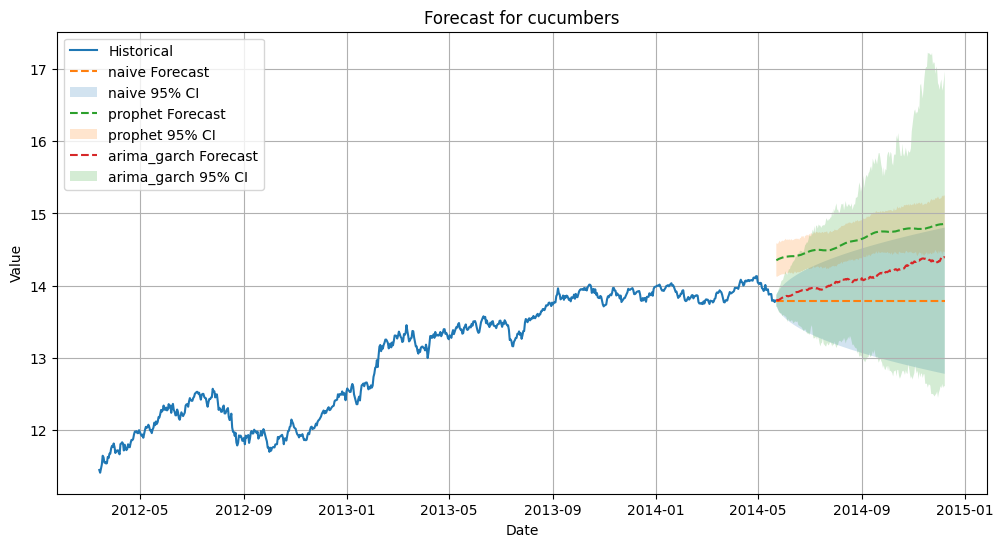

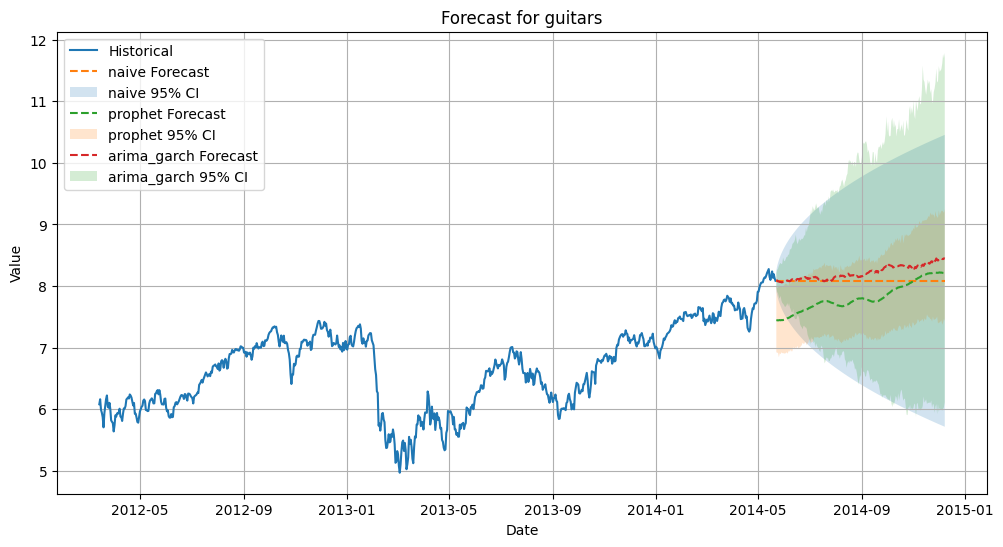

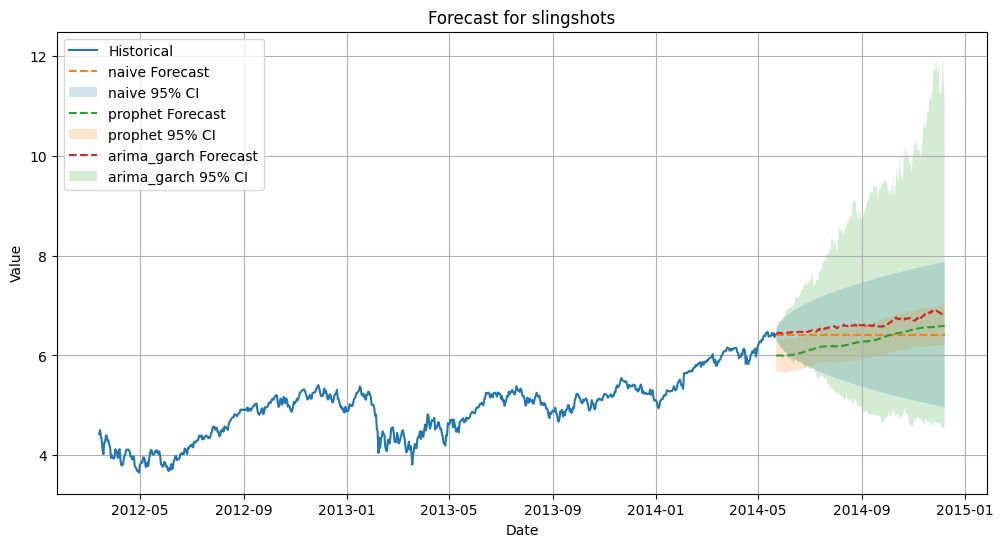

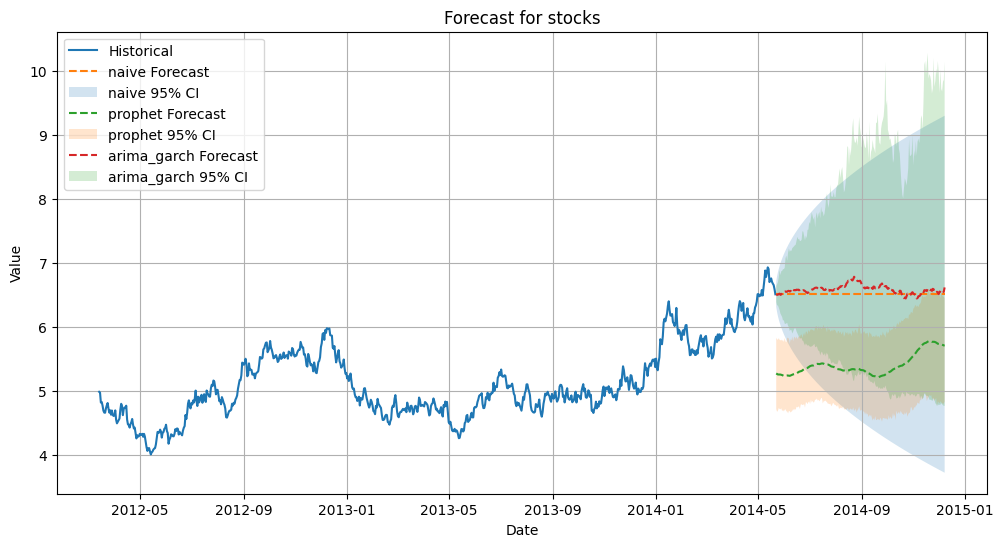

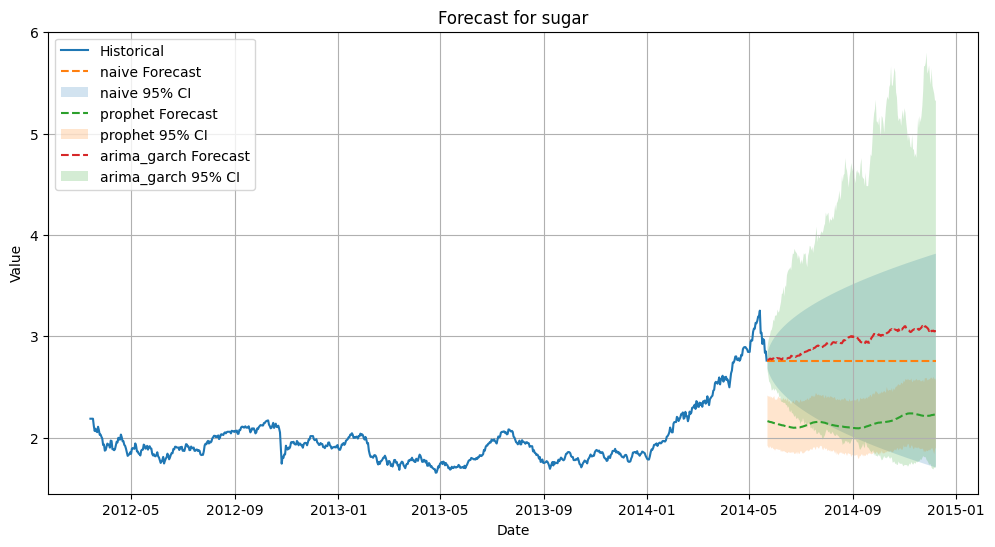

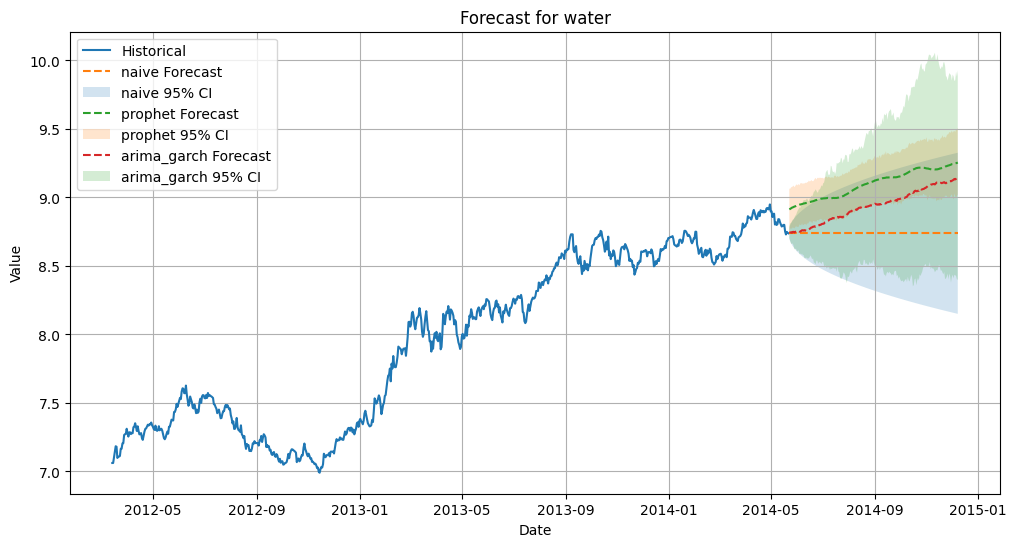

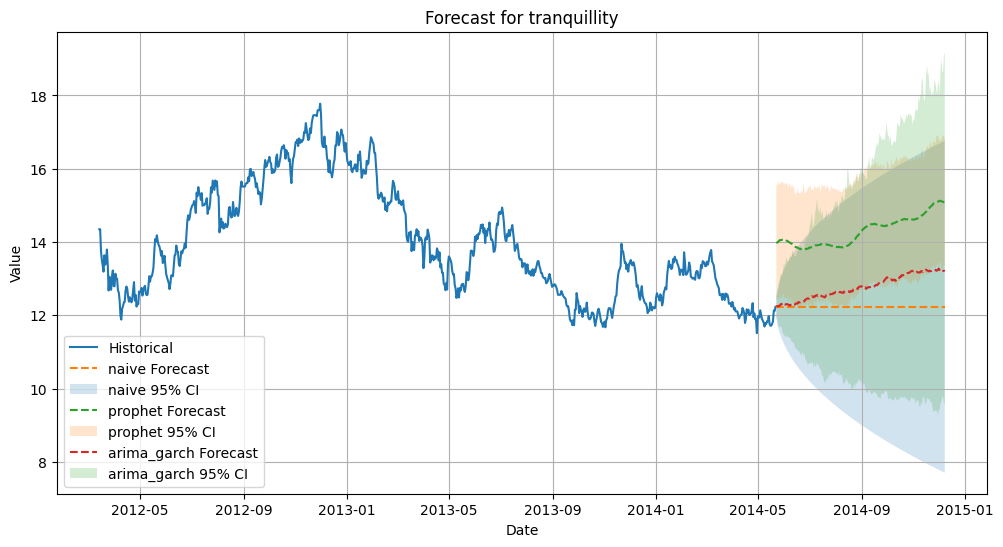

In [83]:
# Plot forecasts for each series
for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Get historical data
    historical_data = df_interpolated[series_name]
    historical_dates = historical_data.index

    # Get forecast data for all models
    forecast_data = [r for r in results if r['series'] == series_name and 'final_forecast' in r]

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(historical_dates[-800:], historical_data[-800:], label='Historical')

    # Plot each model's forecast
    for result in forecast_data:
        model = result['model']
        forecast = result['final_forecast']
        lower_bound = result['lower_bound']
        upper_bound = result['upper_bound']
        forecast_dates = result['forecast_dates']

        # Plot forecast
        plt.plot(forecast_dates, forecast[-200:], label=f'{model} Forecast', linestyle='--')
        # Plot confidence intervals
        plt.fill_between(forecast_dates, lower_bound[-200:], upper_bound[-200:], alpha=0.2, label=f'{model} 95% CI')

    plt.title(f'Forecast for {series_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)


# Rolling window with Monte Carlo, ARIMA+GARCH

## No BoxCox

In [85]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from collections import Counter
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# Suppress library version warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

results = []
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=200)

for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Prepare data
    train_data = df_interpolated[series_name][:-200]
    true_future = df_interpolated[series_name][-200:]

    # Ensure train_data has daily frequency
    train_data.index = pd.DatetimeIndex(train_data.index, freq='D')

    returns = np.log(train_data).diff().dropna()
    returns.index = pd.DatetimeIndex(returns.index).to_period('D').to_timestamp()

    # Check variance of returns
    returns_var = np.var(returns)
    print(f"Series {series_name}, Variance of returns: {returns_var}")
    if returns_var < 1e-6:
        print(f"⚠️ Warning: Low variance in returns for {series_name}, ARIMA may be unstable")

    # Lists to store metrics across folds
    fold_metrics = []

    # Rolling window CV
    for fold, (train_idx, test_idx) in enumerate(tscv.split(returns)):
        train_returns = returns.iloc[train_idx]
        train_prices = train_data.iloc[train_idx]
        test_prices = train_data.iloc[test_idx]

        # Naive baseline model
        naive_forecast = np.full(200, train_prices.iloc[-1])
        naive_rmse = np.sqrt(((naive_forecast - test_prices) ** 2).mean())
        naive_mae = mean_absolute_error(test_prices, naive_forecast)
        naive_mape = mean_absolute_percentage_error(test_prices, naive_forecast)
        fold_metrics.append({'fold': fold, 'model': 'naive', 'rmse': naive_rmse, 'mae': naive_mae, 'mape': naive_mape})

        # Prophet
        prophet_df = pd.DataFrame({
            'ds': train_prices.index,
            'y': train_prices.values})

        # can try setting things like daily_seasonality=True, yearly_seasonality=True)
        # but right now just use default
        prophet_model = Prophet()
        prophet_model.fit(prophet_df)
        future = prophet_model.make_future_dataframe(periods=200, freq='D')
        prophet_forecast = prophet_model.predict(future)

        # Align forecast with test period
        #test_dates = pd.to_datetime(test_prices.index)
        #prophet_point_forecast = prophet_forecast['yhat'][-200:]
        # Ensure date format matches Prophet's forecast format
        test_dates = pd.to_datetime(test_prices.index).normalize()

        # Prophet returns full forecast; grab the last 200 matching future dates
        forecast_start = test_dates.min()
        forecast_end = test_dates.max()
        prophet_point_forecast = prophet_forecast[
            (prophet_forecast['ds'] >= forecast_start) & (prophet_forecast['ds'] <= forecast_end)
        ]['yhat'].values

        # Fallback if misalignment persists
        if len(prophet_point_forecast) != 200:
            print(f"⚠️ ⚠️ ⚠️ ⚠️ ⚠️ Prophet forecast misalignment in fold {fold} for {series_name}")
            #prophet_point_forecast = np.full(200, train_prices.iloc[-1])  # fallback to naive


        prophet_rmse = np.sqrt(((prophet_point_forecast - test_prices) ** 2).mean())
        prophet_mae = mean_absolute_error(test_prices, prophet_point_forecast)
        prophet_mape = mean_absolute_percentage_error(test_prices, prophet_point_forecast) * 100
        fold_metrics.append({
            'fold': fold,
            'model': 'prophet',
            'rmse': prophet_rmse,
            'mae': prophet_mae,
            'mape': prophet_mape
        })

        # ARIMA order selection
        # maybe get p and q to start_p = 1, start_q = 1 to avoid zero coefficients
        arima_model = auto_arima(train_returns, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
        arima_order = arima_model.order
        arima_result = ARIMA(train_returns, order=arima_order).fit()

        # Ljung - Box and ARCH-LM tests
        residuals = arima_result.resid.dropna()
        arch_needed = False
        if len(residuals) < 10 or np.isclose(residuals.var(), 0):
          print(f"Fold {fold}: Residuals too few / variance ~ 0 - skip tests.")
        else:
          max_lag = min(20, len(residuals) // 5)
          lb_p = acorr_ljungbox(residuals, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
          arch_p = het_arch(residuals, nlags=min(10, max_lag))[1]
          print(f"Fold {fold}, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
          print(f"Fold {fold}, ARCH-LM p={arch_p:.3f}")
          arch_needed = arch_p < 0.05

        # GARCH model

        # Default to zero if GARCH not needed
        garch_result = None
        var_garch = np.zeros(200)

        if arch_needed:
          garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (2, 3), (3, 3)]
          best_garch_aic = float('inf')
          best_garch_order = None
          best_garch_result = None

          for garch_order in garch_orders:
              garch_model = arch_model(residuals, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
              garch_result = garch_model.fit(disp='off')

              if garch_result.aic < best_garch_aic:
                  best_garch_aic = garch_result.aic
                  best_garch_order = garch_order
                  best_garch_result = garch_result

          # Check GARCH stationarity (sum of alpha + beta < 1)
          alpha = best_garch_result.params.get('alpha[1]', 0)
          beta = best_garch_result.params.get('beta[1]', 0)
          if alpha + beta >= 1:
              print(f"⚠️ Warning: GARCH model may be non-stationary for {series_name}, fold {fold}, alpha + beta = {alpha + beta}")

          garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
          var_garch = garch_forecast.variance.values[-1, :]

        print(" -------- GARCH VARIANCE------ ")
        print(f"Fold {fold}, Max GARCH variance: {var_garch.max()}")

        # Forecasting
        horizon = 200
        n_simulations = 100
        last_log_price = np.log(train_prices.iloc[-1])
        last_return = arima_result.resid.iloc[-1]

        phi = arima_result.params.get('ar.L1', 0)
        theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
        mu = arima_result.params.get('const', 0)
        eps_prev = [0.0] * arima_order[2] if arima_order[2] > 0 else []

        simulated_paths = np.zeros((n_simulations, horizon))
        for i in range(n_simulations):
            r_prev = last_return
            eps_hist = eps_prev.copy()
            sim_returns = []
            for t in range(horizon):
                std_dev = np.sqrt(var_garch[t] + 1e-8)
                eps_t = np.random.normal(0, std_dev)

                ma_part = sum(theta[j] * eps_hist[j] for j in range(len(theta))) if theta else 0

                r_t = mu + phi * r_prev + ma_part + eps_t

                sim_returns.append(r_t)
                r_prev = r_t
                eps_hist = [eps_t] + eps_hist[:-1]
            sim_log_prices = last_log_price + np.cumsum(sim_returns)
            simulated_paths[i, :] = np.exp(sim_log_prices)

        point_forecast = simulated_paths.mean(axis=0)
        print(f"Fold {fold}, Max simulated prices: {simulated_paths.max()}")
        print(f"Fold {fold}, Max point forecast: {point_forecast.max()}")

        # Metrics for this fold
        # fix these, should not be true future, use test_prices
        rmse = np.sqrt(((point_forecast - test_prices) ** 2).mean())
        mae = mean_absolute_error(test_prices, point_forecast)
        mape = mean_absolute_percentage_error(test_prices, point_forecast)

        fold_metrics.append({
            'fold': fold,
            'model': 'arima_garch',
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'arima_order': arima_order,
            'garch_order': best_garch_order if arch_needed else None
        })

    # Average metrics across folds
    metrics_df = pd.DataFrame(fold_metrics)
    avg_metrics = metrics_df.groupby('model')[['rmse', 'mae', 'mape']].mean().reset_index()

    # Store CV results
    for _, row in avg_metrics.iterrows():
        result = {
            'series': series_name,
            'model': row['model'],
            'rmse': row['rmse'],
            'mae': row['mae'],
            'mape': row['mape']
        }
        if row['model'] == 'arima_garch':
            # Get most frequent orders across folds
            arima_orders = [str(m['arima_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            garch_orders = [str(m['garch_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            result['arima_order'] = eval(Counter(arima_orders).most_common(1)[0][0])
            result['garch_order'] = eval(Counter(garch_orders).most_common(1)[0][0])
        results.append(result)


    # ---------------  Final Forecasts ------------
    # Train on full df_interpolated and forecast 200 unknown values
    print("STARTING FINAL FORECAST ")
    full_train_data = df_interpolated[series_name]
    full_train_data.index = pd.DatetimeIndex(full_train_data.index, freq='D')
    returns = np.log(full_train_data).diff().dropna()
    returns.index = pd.DatetimeIndex(returns.index).to_period('D').to_timestamp(freq='D')

    # Generate future dates
    last_date = full_train_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=200, freq='D')

    # Naive Baseline
    naive_final_forecast = np.full(200, full_train_data.iloc[-1])
    hist_std = full_train_data.diff().dropna().std() * np.sqrt(np.arange(1, 201))  # Widening CI
    naive_lower_bound = naive_final_forecast - 1.96 * hist_std  # 95% CI
    naive_upper_bound = naive_final_forecast + 1.96 * hist_std

    results.append({
        'series': series_name,
        'model': 'naive',
        'final_forecast': naive_final_forecast,
        'lower_bound': naive_lower_bound,
        'upper_bound': naive_upper_bound,
        'forecast_dates': future_dates
    })

    # Prophet
    prophet_df = pd.DataFrame({'ds': full_train_data.index, 'y': full_train_data.values})
    prophet_model = Prophet()
    prophet_model.fit(prophet_df)

    future = prophet_model.make_future_dataframe(periods=200)
    prophet_forecast = prophet_model.predict(future)
    prophet_final_forecast = prophet_forecast['yhat'].values
    prophet_lower_bound = prophet_forecast['yhat_lower'].values
    prophet_upper_bound = prophet_forecast['yhat_upper'].values
    results.append({
        'series': series_name,
        'model': 'prophet',
        'final_forecast': prophet_final_forecast,
        'lower_bound': prophet_lower_bound,
        'upper_bound': prophet_upper_bound,
        'forecast_dates': future_dates
    })

    # ARIMA + GARCH (re-run auto_arima and GARCH AIC on full data)
    arima_model = auto_arima(returns, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
    arima_order = arima_model.order
    arima_result = ARIMA(returns, order=arima_order).fit()
    residuals = arima_result.resid.dropna()

    arch_needed = False
    if len(residuals) < 10 or np.isclose(residuals.var(), 0):
        print("Final Forecast: Residuals too few / variance ≈ 0 – skip tests.")
    else:
        max_lag = min(20, len(residuals)//5)
        lb_p = acorr_ljungbox(residuals, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
        arch_p = het_arch(residuals, nlags=min(10, max_lag))[1]
        print(f"Final Forecast, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
        print(f"Final Forecast, ARCH-LM p={arch_p:.3f}")
        arch_needed = arch_p < 0.05

    garch_result = None
    var_garch = np.zeros(200)

    if arch_needed:
      garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2)]
      best_garch_aic = float('inf')
      best_garch_order = None
      best_garch_result = None

      for garch_order in garch_orders:
          garch_model = arch_model(residuals, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
          garch_result = garch_model.fit(disp='off')
          if garch_result.aic < best_garch_aic:
              best_garch_aic = garch_result.aic
              best_garch_order = garch_order
              best_garch_result = garch_result

      if best_garch_result is not None:
            std_resid = best_garch_result.std_resid.dropna()

            # Ljung-Box on standardized residuals
            lb_p_post = acorr_ljungbox(std_resid, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]

            # ARCH-LM test on stadardized residuals
            arch_p_post = het_arch(std_resid, nlags=min(10, max_lag))[1]

            print(f"⚠️ Post-GARCH Ljung-Box p = {lb_p_post:.3f}")
            print(f"⚠️ Post-GARCH ARCH-LM p = {arch_p_post:.3f}")

      garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
      var_garch = garch_forecast.variance.values[-1, :]

    horizon = 200
    n_simulations = 100
    last_log_price = np.log(full_train_data.iloc[-1])
    last_return = arima_result.resid.iloc[-1]

    phi = arima_result.params.get('ar.L1', 0)
    theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
    mu = arima_result.params.get('const', 0)
    eps_prev = [0.0] * arima_order[2]


    simulated_paths = np.zeros((n_simulations, horizon))
    for i in range(n_simulations):

      r_prev = last_return  # Scalar for each simulation
      eps_prev = [0.0] * arima_order[2]  # History of shocks for this simulation
      sim_returns = []

      for t in range(horizon):
          std_dev = np.sqrt(var_garch[t])
          eps_t = np.random.normal(0, std_dev)  # Scalar shock for this simulation
          ma_part = sum(theta[j] * eps_prev[j] for j in range(arima_order[2])) if arima_order[2] > 0 else 0
          r_t = mu + phi * r_prev + ma_part + eps_t
          sim_returns.append(r_t)
          r_prev = r_t
          eps_prev = [eps_t] + eps_prev[:-1]

      sim_log_prices = last_log_price + np.cumsum(sim_returns)
      simulated_paths[i, :] = np.exp(sim_log_prices)

    print(f"Final Forecast, Max simulated prices: {simulated_paths.max()}")
    print(f"Final Forecast, Max point forecast: {simulated_paths.mean(axis=0).max()}")

    arima_garch_final_forecast = simulated_paths.mean(axis=0)
    arima_garch_lower_bound = np.percentile(simulated_paths, 5, axis=0)
    arima_garch_upper_bound = np.percentile(simulated_paths, 95, axis=0)
    results.append({
        'series': series_name,
        'model': 'arima_garch',
        'final_forecast': arima_garch_final_forecast,
        'lower_bound': arima_garch_lower_bound,
        'upper_bound': arima_garch_upper_bound,
        'forecast_dates': future_dates,
        'arima_order': arima_order,
        'garch_order': best_garch_order if arch_needed else None
    })


# Summary of CV results
results_df = pd.DataFrame([r for r in results if 'rmse' in r])
print("Cross-Validation Results Summary:")
print(results_df[['series', 'model', 'rmse', 'mae', 'mape', 'arima_order', 'garch_order']])

# Final forecasts
forecast_df = pd.DataFrame([r for r in results if 'final_forecast' in r])
print("\nFinal Forecasts:")
print(forecast_df[['series', 'model', 'final_forecast', 'lower_bound', 'upper_bound']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/j6deqfn8.json


Series cucumbers, Variance of returns: 1.5827989170076743e-05


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/wczopdl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31759', 'data', 'file=/tmp/tmp1pw36qt8/j6deqfn8.json', 'init=/tmp/tmp1pw36qt8/wczopdl_.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model8vgdsqwo/prophet_model-20250518161942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:19:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 0, Ljung-Box p=0.445 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 7.718775529651848e-05


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/de9os43n.json


Fold 0, Max simulated prices: 13.221949045595945
Fold 0, Max point forecast: 10.973140059573318


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/aic21ycp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19144', 'data', 'file=/tmp/tmp1pw36qt8/de9os43n.json', 'init=/tmp/tmp1pw36qt8/aic21ycp.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelrbw_zrg0/prophet_model-20250518162033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.070 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 2.985629168612419e-05
Fold 1, Max simulated prices: 12.880885515521362
Fold 1, Max point forecast: 11.18357007526292


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/vbx9k15i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55100', 'data', 'file=/tmp/tmp1pw36qt8/1rhf5a0u.json', 'init=/tmp/tmp1pw36qt8/vbx9k15i.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelnulm13ct/prophet_model-20250518162049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.124 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/6g0shh7b.json


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 1.66802004189626e-05
Fold 2, Max simulated prices: 13.420571726482718
Fold 2, Max point forecast: 11.974759063945578


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/j8s29f6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52812', 'data', 'file=/tmp/tmp1pw36qt8/6g0shh7b.json', 'init=/tmp/tmp1pw36qt8/j8s29f6d.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeln12zk9o3/prophet_model-20250518162142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.046 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 2.1833893340884993e-05
Fold 3, Max simulated prices: 14.44098211581146
Fold 3, Max point forecast: 12.177793197689958


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/tdybkls5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/a7q9d_dv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10406', 'data', 'file=/tmp/tmp1pw36qt8/tdybkls5.json', 'init=/tmp/tmp1pw36qt8/a7q9d_dv.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelkafmkcoh/prophet_model-20250518162221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.062 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 1.965022756201483e-05
Fold 4, Max simulated prices: 16.49218651457856
Fold 4, Max point forecast: 13.816866832000388


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/u4vtpfxd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90103', 'data', 'file=/tmp/tmp1pw36qt8/0baqzwn6.json', 'init=/tmp/tmp1pw36qt8/u4vtpfxd.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model2tt8lgp5/prophet_model-20250518162258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:23:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Final Forecast, Ljung-Box p=0.064 (lag 20)
Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


⚠️ Post-GARCH Ljung-Box p = 0.108
⚠️ Post-GARCH ARCH-LM p = 0.428
Final Forecast, Max simulated prices: 16.331883607564063
Final Forecast, Max point forecast: 14.533836714095921


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/z_ug_n_k.json


Series guitars, Variance of returns: 0.0002254188941233319


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/7cf14tyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58495', 'data', 'file=/tmp/tmp1pw36qt8/z_ug_n_k.json', 'init=/tmp/tmp1pw36qt8/7cf14tyh.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model796xy4gr/prophet_model-20250518162405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.072 (lag 20)
Fold 0, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/6f3hpe1i.json


 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0009024053511865983
Fold 0, Max simulated prices: 11.023407593801572
Fold 0, Max point forecast: 5.861350279580453


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/e_6plg1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41941', 'data', 'file=/tmp/tmp1pw36qt8/6f3hpe1i.json', 'init=/tmp/tmp1pw36qt8/e_6plg1q.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model6a2ymnnn/prophet_model-20250518162415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.005 (lag 20)
Fold 1, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/9o_u4a8b.json


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.00027524517458202546
Fold 1, Max simulated prices: 8.62179506074695
Fold 1, Max point forecast: 5.163520978483336


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/_bf4g6t_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66855', 'data', 'file=/tmp/tmp1pw36qt8/9o_u4a8b.json', 'init=/tmp/tmp1pw36qt8/_bf4g6t_.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelga9uz0yl/prophet_model-20250518162436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.002 (lag 20)
Fold 2, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/7h4wbhh1.json


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00024805558995845135
Fold 2, Max simulated prices: 10.56355420797571
Fold 2, Max point forecast: 6.50123448384816


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/p0wz9rs2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50944', 'data', 'file=/tmp/tmp1pw36qt8/7h4wbhh1.json', 'init=/tmp/tmp1pw36qt8/p0wz9rs2.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model5q2go_1h/prophet_model-20250518162445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.010 (lag 20)
Fold 3, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/_bjj0ivx.json


 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.00019526990418619004
Fold 3, Max simulated prices: 11.971473851540486
Fold 3, Max point forecast: 7.550794232271284


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/1cfwd30w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=367', 'data', 'file=/tmp/tmp1pw36qt8/_bjj0ivx.json', 'init=/tmp/tmp1pw36qt8/1cfwd30w.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelg3k71djv/prophet_model-20250518162505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.000 (lag 20)
Fold 4, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/105q5bvb.json


 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.0007952942995343213
Fold 4, Max simulated prices: 14.040623998490792
Fold 4, Max point forecast: 6.222311939918426


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/5qpzi886.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54326', 'data', 'file=/tmp/tmp1pw36qt8/105q5bvb.json', 'init=/tmp/tmp1pw36qt8/5qpzi886.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model34t0wics/prophet_model-20250518162516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Final Forecast, Ljung-Box p=0.001 (lag 20)
Final Forecast, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


⚠️ Post-GARCH Ljung-Box p = 0.350
⚠️ Post-GARCH ARCH-LM p = 0.506
Final Forecast, Max simulated prices: 13.955531438850889
Final Forecast, Max point forecast: 8.488961553401722
Series slingshots, Variance of returns: 0.00021955795572236217


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/46jhezbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/kzlv_e4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18329', 'data', 'file=/tmp/tmp1pw36qt8/46jhezbw.json', 'init=/tmp/tmp1pw36qt8/kzlv_e4v.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelj26w67l1/prophet_model-20250518162529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.739 (lag 20)
Fold 0, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/cq2gmw3q.json


 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0017363633943942617
Fold 0, Max simulated prices: 17.103338940311644
Fold 0, Max point forecast: 4.190547418099583


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/u83doy6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83486', 'data', 'file=/tmp/tmp1pw36qt8/cq2gmw3q.json', 'init=/tmp/tmp1pw36qt8/u83doy6q.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modely6v3hqe2/prophet_model-20250518162605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/s

Fold 1, Ljung-Box p=0.012 (lag 20)
Fold 1, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.00029238461604064983
Fold 1, Max simulated prices: 5.721078561673611
Fold 1, Max point forecast: 3.3330252532612934


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/bztnnl6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/gm4f7r3p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41566', 'data', 'file=/tmp/tmp1pw36qt8/bztnnl6h.json', 'init=/tmp/tmp1pw36qt8/gm4f7r3p.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelk3kwks_p/prophet_model-20250518162634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parame

Fold 2, Ljung-Box p=0.022 (lag 20)
Fold 2, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/4eboijam.json


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00020199846198698035
Fold 2, Max simulated prices: 8.06249381366003
Fold 2, Max point forecast: 4.7669265144077455


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/8ktli5su.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46903', 'data', 'file=/tmp/tmp1pw36qt8/4eboijam.json', 'init=/tmp/tmp1pw36qt8/8ktli5su.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model01xqieax/prophet_model-20250518162712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/s

Fold 3, Ljung-Box p=0.016 (lag 20)
Fold 3, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/i3t973tu.json


 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.00018808444481138422
Fold 3, Max simulated prices: 9.246702895973668
Fold 3, Max point forecast: 5.249641574367306


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/alji57v9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3664', 'data', 'file=/tmp/tmp1pw36qt8/i3t973tu.json', 'init=/tmp/tmp1pw36qt8/alji57v9.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelc8gzdg0u/prophet_model-20250518162739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/st

Fold 4, Ljung-Box p=0.000 (lag 20)
Fold 4, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/hlo6w_84.json


 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.0005597988666186638
Fold 4, Max simulated prices: 9.14536563818808
Fold 4, Max point forecast: 4.825584764491626


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/3vv_zs_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73753', 'data', 'file=/tmp/tmp1pw36qt8/hlo6w_84.json', 'init=/tmp/tmp1pw36qt8/3vv_zs_1.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelicwanu38/prophet_model-20250518162825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Final Forecast, Ljung-Box p=0.015 (lag 20)
Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.003
⚠️ Post-GARCH ARCH-LM p = 0.961


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/zjn8v0ad.json


Final Forecast, Max simulated prices: 9.006647442349857
Final Forecast, Max point forecast: 6.632308939144102
Series stocks, Variance of returns: 0.00021966421013982172


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/diiu1_u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78910', 'data', 'file=/tmp/tmp1pw36qt8/zjn8v0ad.json', 'init=/tmp/tmp1pw36qt8/diiu1_u7.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelat0i6i7y/prophet_model-20250518162911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:29:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Fold 0, Ljung-Box p=0.988 (lag 20)
Fold 0, ARCH-LM p=0.433
 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0
Fold 0, Max simulated prices: 4.748877218108082
Fold 0, Max point forecast: 4.74786938914364


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/cnbn0au9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48440', 'data', 'file=/tmp/tmp1pw36qt8/rzeij4r5.json', 'init=/tmp/tmp1pw36qt8/cnbn0au9.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelire09u7q/prophet_model-20250518162923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:29:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:29:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/p7cxe3bb.json


Fold 1, Ljung-Box p=0.982 (lag 20)
Fold 1, ARCH-LM p=0.572
 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.0
Fold 1, Max simulated prices: 4.592937014545596
Fold 1, Max point forecast: 4.591673975893606


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/i4fi9bwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43541', 'data', 'file=/tmp/tmp1pw36qt8/p7cxe3bb.json', 'init=/tmp/tmp1pw36qt8/i4fi9bwo.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelx20mhvjv/prophet_model-20250518162934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:29:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:29:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fold 2, Ljung-Box p=0.994 (lag 20)
Fold 2, ARCH-LM p=0.715
 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.0
Fold 2, Max simulated prices: 4.9813193735501855
Fold 2, Max point forecast: 4.980341353910029


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/mnzzt0sf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/0fendv3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62569', 'data', 'file=/tmp/tmp1pw36qt8/mnzzt0sf.json', 'init=/tmp/tmp1pw36qt8/0fendv3w.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model4y7777k3/prophet_model-20250518162944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:29:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:29:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/brq6b7kx.json


Fold 3, Ljung-Box p=0.990 (lag 20)
Fold 3, ARCH-LM p=0.804
 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.0
Fold 3, Max simulated prices: 5.762399098400901
Fold 3, Max point forecast: 5.759902220067904


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/krerjetj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77441', 'data', 'file=/tmp/tmp1pw36qt8/brq6b7kx.json', 'init=/tmp/tmp1pw36qt8/krerjetj.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modely1_ri1dw/prophet_model-20250518162954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:29:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fold 4, Ljung-Box p=0.991 (lag 20)
Fold 4, ARCH-LM p=0.759
 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.0
Fold 4, Max simulated prices: 4.714260720898961
Fold 4, Max point forecast: 4.712934393961117


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/n2fi5vij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/779qfmu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56857', 'data', 'file=/tmp/tmp1pw36qt8/n2fi5vij.json', 'init=/tmp/tmp1pw36qt8/779qfmu2.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model9701y55i/prophet_model-20250518163006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/nf4mg2p2.json


Final Forecast, Ljung-Box p=0.953 (lag 20)
Final Forecast, ARCH-LM p=0.772
Final Forecast, Max simulated prices: 6.512328863994762
Final Forecast, Max point forecast: 6.512328863994756
Series sugar, Variance of returns: 0.00023005582357194527


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/3pbyf9wu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52199', 'data', 'file=/tmp/tmp1pw36qt8/nf4mg2p2.json', 'init=/tmp/tmp1pw36qt8/3pbyf9wu.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model56yavxxy/prophet_model-20250518163019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.900 (lag 20)
Fold 0, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/x1246jt3.json


 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0015476214222126055
Fold 0, Max simulated prices: 5.114063228537034
Fold 0, Max point forecast: 2.104942022464621


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/6qu94v4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47444', 'data', 'file=/tmp/tmp1pw36qt8/x1246jt3.json', 'init=/tmp/tmp1pw36qt8/6qu94v4a.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelk_v3st68/prophet_model-20250518163030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.445 (lag 20)
Fold 1, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.00023929593476450947
Fold 1, Max simulated prices: 3.2838197181573467
Fold 1, Max point forecast: 1.9669643928200735


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/ic8arfid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/5eog68ro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32554', 'data', 'file=/tmp/tmp1pw36qt8/ic8arfid.json', 'init=/tmp/tmp1pw36qt8/5eog68ro.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model3mfpt_f7/prophet_model-20250518163110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.492 (lag 20)
Fold 2, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/2ehy81ed.json


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.000233982181358321
Fold 2, Max simulated prices: 4.294484322134581
Fold 2, Max point forecast: 2.1731325499839986


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/_cx2x2bd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80255', 'data', 'file=/tmp/tmp1pw36qt8/2ehy81ed.json', 'init=/tmp/tmp1pw36qt8/_cx2x2bd.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modela3hbzo7k/prophet_model-20250518163142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:31:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:31:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.464 (lag 20)
Fold 3, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/rmv1xwl5.json


 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.00023673459564277325
Fold 3, Max simulated prices: 3.9643655079020483
Fold 3, Max point forecast: 2.2305926027106397


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/sl50f9fh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27624', 'data', 'file=/tmp/tmp1pw36qt8/rmv1xwl5.json', 'init=/tmp/tmp1pw36qt8/sl50f9fh.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelrppiuowa/prophet_model-20250518163216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:32:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:32:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.623 (lag 20)
Fold 4, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/eabzr047.json


 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.00023574683689064514
Fold 4, Max simulated prices: 3.568359871996115
Fold 4, Max point forecast: 1.8150683780043737


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/8htcin5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51961', 'data', 'file=/tmp/tmp1pw36qt8/eabzr047.json', 'init=/tmp/tmp1pw36qt8/8htcin5h.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model_ywrfif_/prophet_model-20250518163255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:32:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Final Forecast, Ljung-Box p=0.670 (lag 20)
Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.066
⚠️ Post-GARCH ARCH-LM p = 0.806
Final Forecast, Max simulated prices: 6.690295208152517
Final Forecast, Max point forecast: 3.005511506311484
Series water, Variance of returns: 1.2326905302187694e-05


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/a_zvzx2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/y3ueetm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86205', 'data', 'file=/tmp/tmp1pw36qt8/a_zvzx2x.json', 'init=/tmp/tmp1pw36qt8/y3ueetm8.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model67mwq6jz/prophet_model-20250518163337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:33:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:33:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
 

Fold 0, Ljung-Box p=0.323 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 2.9457577915016975e-05
Fold 0, Max simulated prices: 7.522006081859895
Fold 0, Max point forecast: 6.514106878927981


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/iektkn25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52871', 'data', 'file=/tmp/tmp1pw36qt8/pg_u_30t.json', 'init=/tmp/tmp1pw36qt8/iektkn25.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelcdihufue/prophet_model-20250518163351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.099 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 1.4107815366851504e-05
Fold 1, Max simulated prices: 7.743913715860835
Fold 1, Max point forecast: 6.901421612792189


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/503rvhyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33019', 'data', 'file=/tmp/tmp1pw36qt8/grfzkto8.json', 'init=/tmp/tmp1pw36qt8/503rvhyo.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelqwyw3qhh/prophet_model-20250518163406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:34:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.110 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 1.13018467874115e-05
Fold 2, Max simulated prices: 8.147870940783207
Fold 2, Max point forecast: 7.199451283656073


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/rx1xmpza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/wcff0yf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11320', 'data', 'file=/tmp/tmp1pw36qt8/rx1xmpza.json', 'init=/tmp/tmp1pw36qt8/wcff0yf7.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelkdbcxacp/prophet_model-20250518163425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:34:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.192 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 1.2079547937693567e-05
Fold 3, Max simulated prices: 8.093106325450789
Fold 3, Max point forecast: 7.245480856723625


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/hic80l8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64565', 'data', 'file=/tmp/tmp1pw36qt8/kqwbs55y.json', 'init=/tmp/tmp1pw36qt8/hic80l8r.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeljxz2qvi0/prophet_model-20250518163448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:34:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:34:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.121 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 4.6573857493797474e-05
Fold 4, Max simulated prices: 10.453365068264215
Fold 4, Max point forecast: 8.4461998848308


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/g3vxr31s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16860', 'data', 'file=/tmp/tmp1pw36qt8/pcobosf3.json', 'init=/tmp/tmp1pw36qt8/g3vxr31s.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelfc41ubry/prophet_model-20250518163504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:35:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:35:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Final Forecast, Ljung-Box p=0.313 (lag 20)
Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.737
⚠️ Post-GARCH ARCH-LM p = 0.757


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run pr

Final Forecast, Max simulated prices: 10.004831699288559
Final Forecast, Max point forecast: 9.057681734494624
Series tranquillity, Variance of returns: 0.00015742639415925125


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/92qk680f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37435', 'data', 'file=/tmp/tmp1pw36qt8/an8o6b_l.json', 'init=/tmp/tmp1pw36qt8/92qk680f.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modela3yqo7t8/prophet_model-20250518163522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:35:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:35:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.410 (lag 20)
Fold 0, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/tkqldg7d.json


 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0003339619063909959
Fold 0, Max simulated prices: 152.49280550011403
Fold 0, Max point forecast: 22.288814568294985


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/mmhydvhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66116', 'data', 'file=/tmp/tmp1pw36qt8/tkqldg7d.json', 'init=/tmp/tmp1pw36qt8/mmhydvhz.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelpxfrifed/prophet_model-20250518163550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:35:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:35:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.307 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.0004398156318029496
Fold 1, Max simulated prices: 142.22250007443864
Fold 1, Max point forecast: 18.665410579072855


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/j8z1s0oe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/kexsk8jp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43733', 'data', 'file=/tmp/tmp1pw36qt8/j8z1s0oe.json', 'init=/tmp/tmp1pw36qt8/kexsk8jp.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeldsiy9j5f/prophet_model-20250518163706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:37:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:37:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.152 (lag 20)
Fold 2, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/lm59svtu.json


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00042154335044718296
Fold 2, Max simulated prices: 28.992018616052697
Fold 2, Max point forecast: 15.175800427581516


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/hjeowe98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41952', 'data', 'file=/tmp/tmp1pw36qt8/lm59svtu.json', 'init=/tmp/tmp1pw36qt8/hjeowe98.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeldu6s4c8c/prophet_model-20250518163715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:37:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:37:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.109 (lag 20)
Fold 3, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/f_ahn_x5.json


 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.0001583393655945567
Fold 3, Max simulated prices: 29.21009968463211
Fold 3, Max point forecast: 17.156788405075805


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/xlvudtgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60153', 'data', 'file=/tmp/tmp1pw36qt8/f_ahn_x5.json', 'init=/tmp/tmp1pw36qt8/xlvudtgt.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelk9zavlzo/prophet_model-20250518163727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:37:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:37:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.047 (lag 20)
Fold 4, ARCH-LM p=0.000


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/ivpwizy7.json


 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.00027229172758803146
Fold 4, Max simulated prices: 23.341704876858127
Fold 4, Max point forecast: 14.195177431211489


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/mwzsk327.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62409', 'data', 'file=/tmp/tmp1pw36qt8/ivpwizy7.json', 'init=/tmp/tmp1pw36qt8/mwzsk327.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelf7hus136/prophet_model-20250518163739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:37:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:37:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Final Forecast, Ljung-Box p=0.057 (lag 20)
Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


⚠️ Post-GARCH Ljung-Box p = 0.062
⚠️ Post-GARCH ARCH-LM p = 0.816
Final Forecast, Max simulated prices: 18.153071888190063
Final Forecast, Max point forecast: 12.400785958667816
Cross-Validation Results Summary:
          series        model      rmse       mae       mape arima_order  \
0      cucumbers  arima_garch  0.429863  0.352989   0.029142   (1, 0, 2)   
1      cucumbers        naive  0.603771  0.527199   0.043276         NaN   
2      cucumbers      prophet  0.485922  0.440046   3.690486         NaN   
3        guitars  arima_garch  0.756365  0.636320   0.118958   (0, 0, 0)   
4        guitars        naive  0.734892  0.604169   0.108525         NaN   
5        guitars      prophet  1.623989  1.538905  28.450551         NaN   
6     slingshots  arima_garch  0.621026  0.547820   0.158100   (2, 0, 2)   
7     slingshots        naive  0.514113  0.450496   0.118512         NaN   
8     slingshots      prophet  1.196181  1.128936  30.149416         NaN   
9         stocks  arima_garc

In [86]:
results_df

,series,model,rmse,mae,mape,arima_order,garch_order
0,cucumbers,arima_garch,0.429863,0.352989,0.029142,"(1, 0, 2)","(2, 3)"
1,cucumbers,naive,0.603771,0.527199,0.043276,NaN,NaN
2,cucumbers,prophet,0.485922,0.440046,3.690486,NaN,NaN
3,guitars,arima_garch,0.756365,0.636320,0.118958,"(0, 0, 0)","(3, 3)"
4,guitars,naive,0.734892,0.604169,0.108525,NaN,NaN
5,guitars,prophet,1.623989,1.538905,28.450551,NaN,NaN
6,slingshots,arima_garch,0.621026,0.547820,0.158100,"(2, 0, 2)","(2, 3)"
7,slingshots,naive,0.514113,0.450496,0.118512,NaN,NaN
8,slingshots,prophet,1.196181,1.128936,30.149416,NaN,NaN
9,stocks,arima_garch,0.500207,0.429088,0.085641,"(0, 0, 0)",None


In [87]:
forecast_df

,series,model,final_forecast,lower_bound,upper_bound,forecast_dates,arima_order,garch_order
0,cucumbers,naive,"[13.79194942177011, 13.79194942177011, 13.7919...","[13.720359948451321, 13.690706617679533, 13.66...","[13.863538895088897, 13.893192225860686, 13.91...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
1,cucumbers,prophet,"[6.183469264930955, 6.1905669454561085, 6.1967...","[5.937750524216822, 5.9367841760217575, 5.9806...","[6.432749313882866, 6.401106719694809, 6.43186...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
2,cucumbers,arima_garch,"[13.79667235626157, 13.800966303830064, 13.802...","[13.725823223695444, 13.713512317991247, 13.68...","[13.85975806802571, 13.899221301994684, 13.943...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(1, 0, 2)","(2, 1)"
3,guitars,naive,"[8.08491746257293, 8.08491746257293, 8.0849174...","[7.9173134493709725, 7.847889593994562, 7.7946...","[8.252521475774888, 8.321945331151298, 8.37521...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
4,guitars,prophet,"[3.045407404292647, 3.0431675780005114, 3.0454...","[2.4384005524267267, 2.5365235752168287, 2.480...","[3.6061574383479003, 3.5988678128736584, 3.586...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
5,guitars,arima_garch,"[8.075649197164934, 8.083959439479818, 8.08675...","[7.942357296680234, 7.892151734825722, 7.84421...","[8.201856121574679, 8.298653249330377, 8.28693...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(0, 0, 0)","(2, 1)"
6,slingshots,naive,"[6.419011268155251, 6.419011268155251, 6.41901...","[6.31587819759022, 6.273159081033004, 6.240379...","[6.522144338720282, 6.564863455277498, 6.59764...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
7,slingshots,prophet,"[2.1225503751571866, 2.1250268797956764, 2.127...","[1.8127182923785705, 1.7992376963798151, 1.784...","[2.467247529806406, 2.464653444188362, 2.42114...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
8,slingshots,arima_garch,"[6.41327428881832, 6.417191013284326, 6.415001...","[6.330188129372818, 6.299041283785678, 6.26889...","[6.494176680616218, 6.52302815824403, 6.539923...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(2, 0, 2)","(2, 2)"
9,stocks,naive,"[6.512971260506997, 6.512971260506997, 6.51297...","[6.315959398297992, 6.234354413022643, 6.17173...","[6.709983122716001, 6.79158810799135, 6.854205...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN


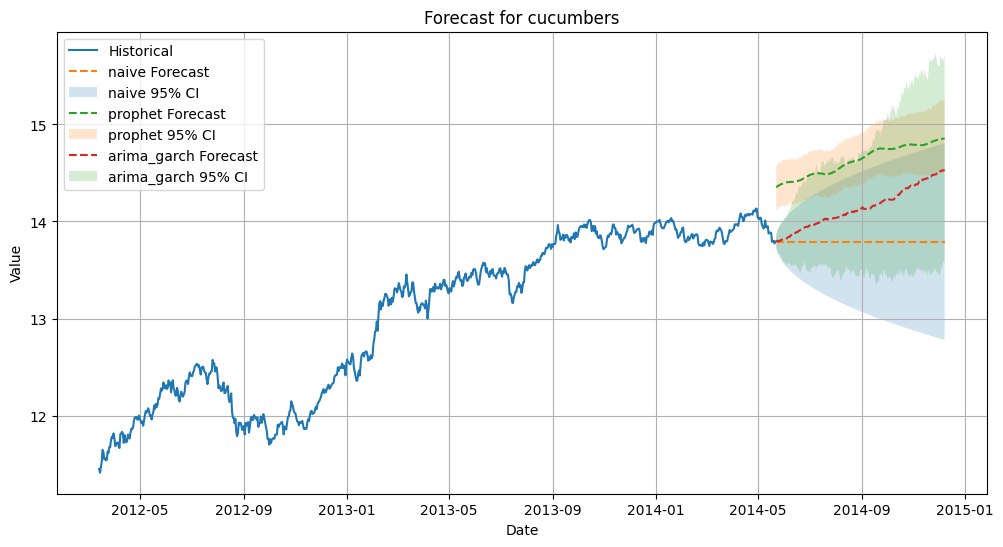

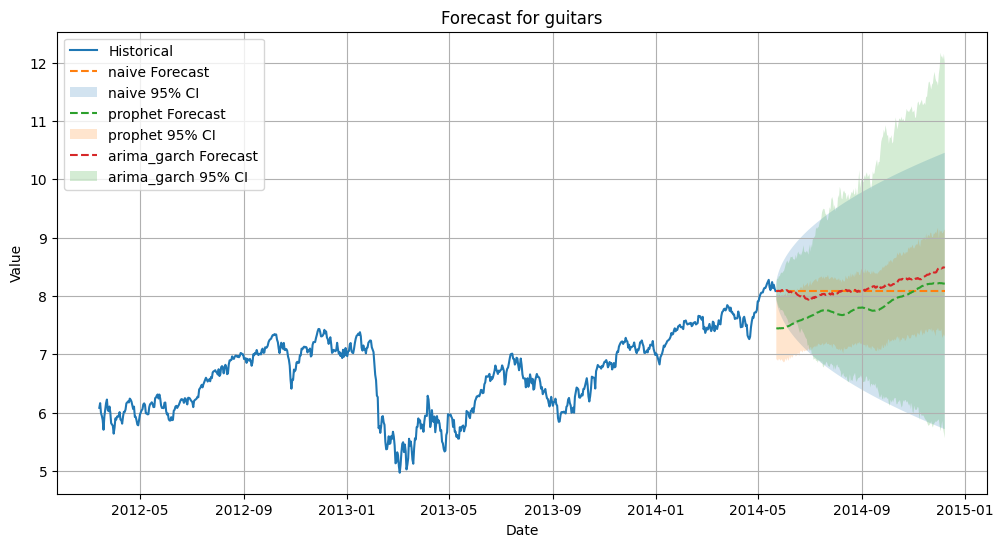

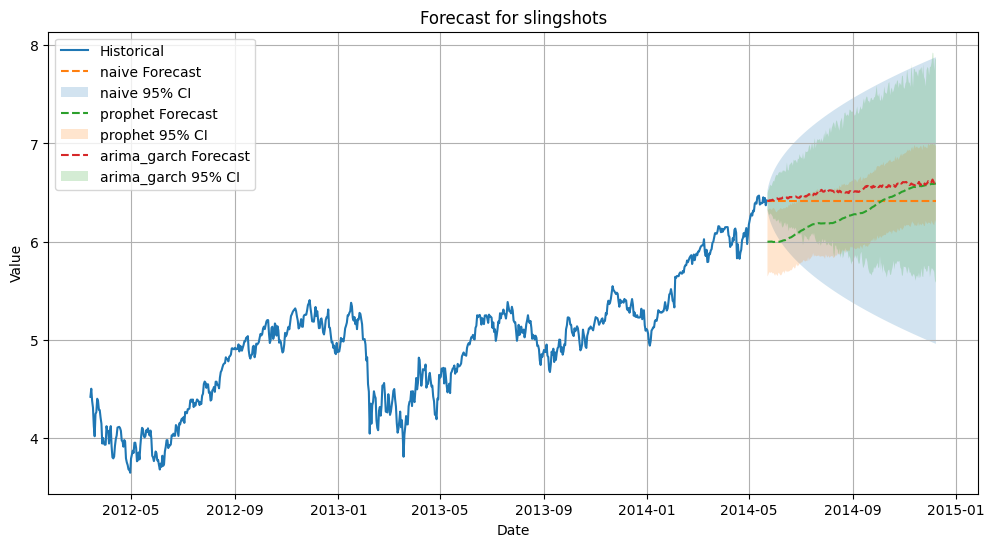

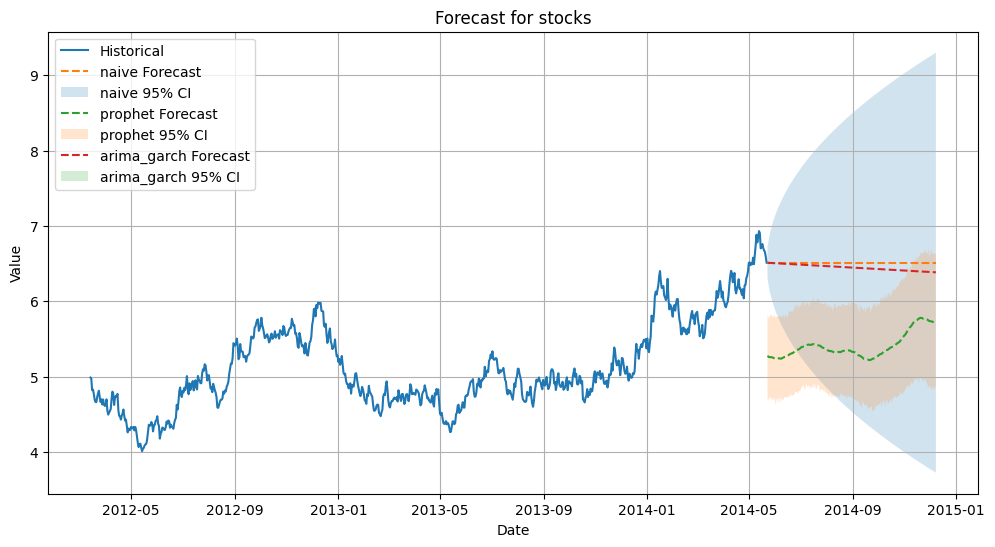

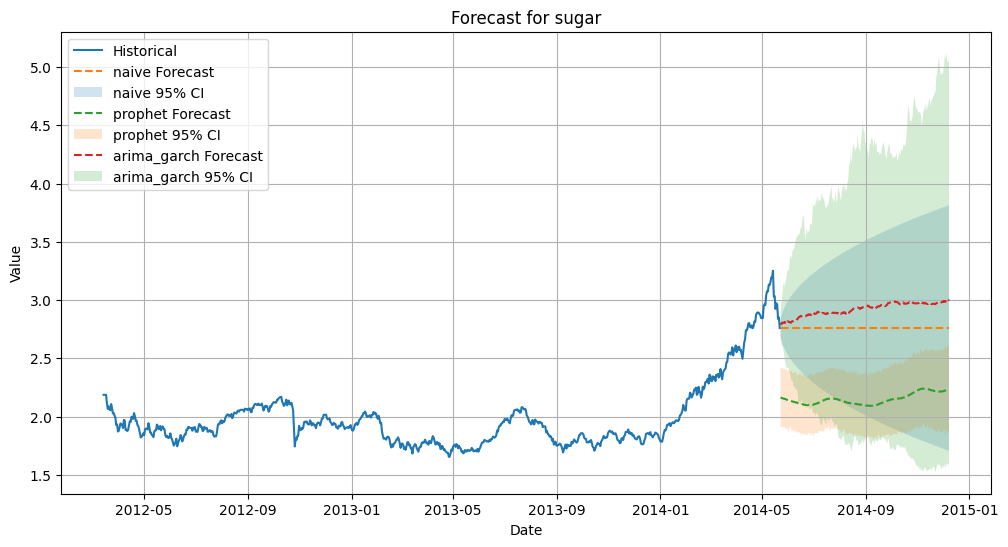

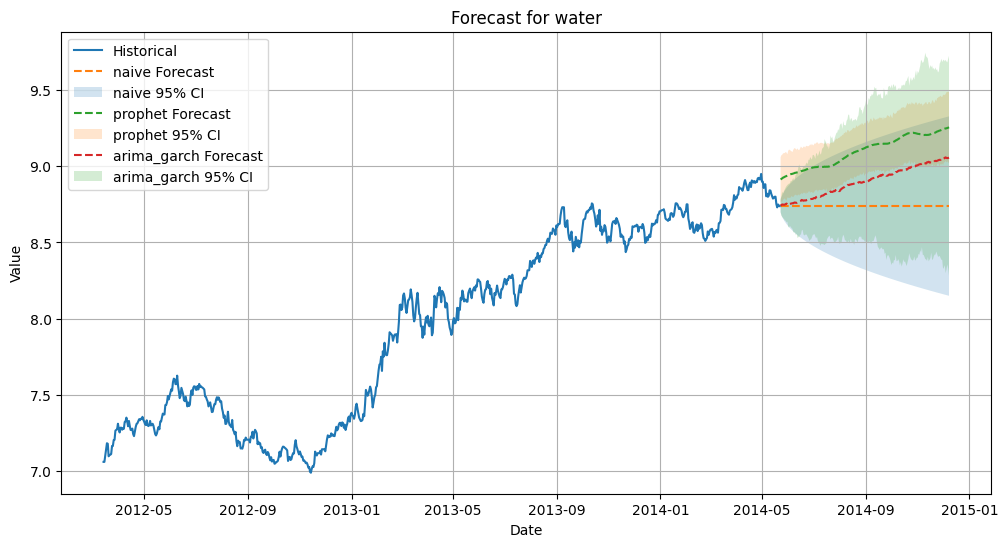

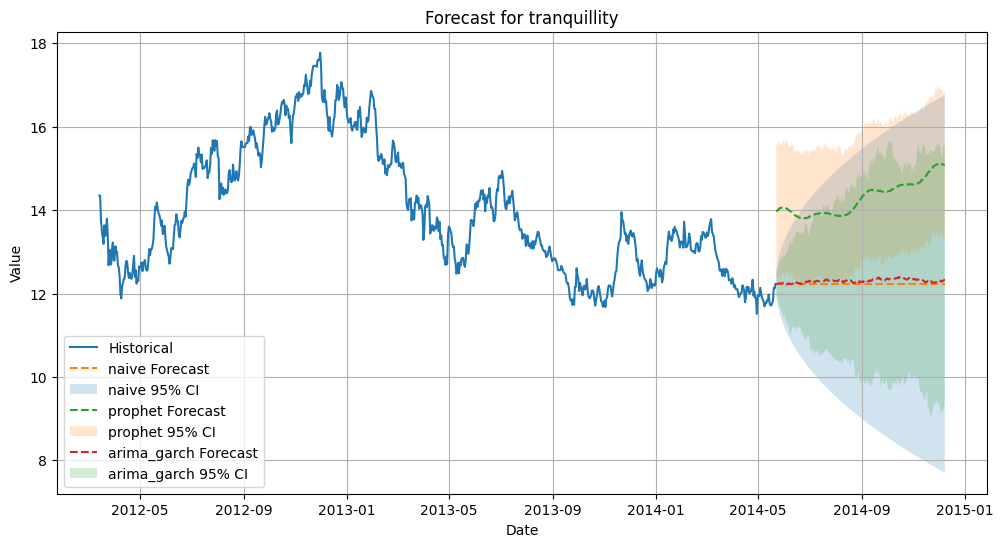

In [88]:
# Plot forecasts for each series
for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Get historical data
    historical_data = df_interpolated[series_name]
    historical_dates = historical_data.index

    # Get forecast data for all models
    forecast_data = [r for r in results if r['series'] == series_name and 'final_forecast' in r]

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(historical_dates[-800:], historical_data[-800:], label='Historical')

    # Plot each model's forecast
    for result in forecast_data:
        model = result['model']
        forecast = result['final_forecast']
        lower_bound = result['lower_bound']
        upper_bound = result['upper_bound']
        forecast_dates = result['forecast_dates']

        # Plot forecast
        plt.plot(forecast_dates, forecast[-200:], label=f'{model} Forecast', linestyle='--')
        # Plot confidence intervals
        plt.fill_between(forecast_dates, lower_bound[-200:], upper_bound[-200:], alpha=0.2, label=f'{model} 95% CI')

    plt.title(f'Forecast for {series_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)


## Rolling window CV

TimeSeriesSplit is designed for time series CV. Ensures that the training set always preceds the test set, respect the temporal order of the data.

- n_splits = k, creates k folds each with a training set and a test set. The training set grows with each fold, and the tes set slides forward in time.

In our case:

5200 observations. (-1 from .diff()), splits = 5

- Training set size: Increases with each fold, calculated as:
  - Total number of observations is divided such that the last fold's test set ends the final observation
  - Training set size for each fold is determined by ensuring the test sets cover the last 5 * 200 = 1000 observations.

Splits are computed as:

Split 1:
- Train: Indices 0 to 4,199 (first 4,200 observations).
- Test: Indices 4,200 to 4,399 (next 200 observations).

Split 2:
- Train: Indices 0 to 4,399 (first 4,400 observations).
- Test: Indices 4,400 to 4,599 (next 200 observations).

Split 3:
- Train: Indices 0 to 4,599 (first 4,600 observations).
- Test: Indices 4,600 to 4,799 (next 200 observations).

Split 4:
- Train: Indices 0 to 4,799 (first 4,800 observations).
- Test: Indices 4,800 to 4,999 (next 200 observations).

Split 5:
- Train: Indices 0 to 4,999 (first 5,000 observations).
- Test: Indices 5,000 to 5,199 (last 200 observations).


## Calculation Details
- The test sets cover the last 1,000 observations (5 splits × 200 test observations).

- The first test set starts at index 5,199 - 1,000 = 4,199 (after the first 4,200 observations).

- Each subsequent test set shifts forward by 200 observations.

- The training set grows by 200 observations per fold, starting from 4,200 in the first fold to 5,000 in the last fold.


## Final Forecast:
In time series forecasting, CV is used for evaluation and model selection, but the final forecast typically uses the full dataset to maximize predictive power. This is especially important for long-horizon forecasts (our 200 steps), where small improvements in parameter estimates can compound over time.

# CV is not redundant

Rolling window CV is not redundant, even if we re-fit the model on the full dataset, because it serves a different purpose than the final forecast:

- CV Purpose: Evaluate and compare models (ARIMA + GARCH, baseline, Prophet) and validate parameter choices across multiple periods to ensure robustness and generalization.

- Final Forecast Purpose: Produce the most accurate 200-step-ahead predictions using all available data.

Without CV, we have no reliable way to:

- Compare ARIMA + GARCH against baseline or Prophet models.

- Assess whether the model generalizes across different periods of our data.

- Detect potential issues like overfitting or unstable parameter selection.



# IMRPOVEMENTS OF FORECAST

Instead of using all data which contains crashes, limit the data to stable periods, might better model the future.